<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2025/blob/main/Module_2/Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Homework 4 for the MSE510 Course
- Instructor Sergei V. Kalinin, sergei2@utk.edu
- Please provide your name in the beginning of the notebook
- To submit the homework, please share it with my gmail address (available on Canvas)

In [1]:
!pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.9 MB/s eta 0:00:00


In [2]:
import pysr

[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.11.3 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.11/julia-1.11.3-linux-x86_64.tar.gz
             downloaded 58.1 MB of 253.8 MB
             down

# Loading Data

Run the code cell below

In [3]:
!gdown https://drive.google.com/uc?id=1UC6bu5nVFRBhHIL698jk0zt3AuDqREkV
!unzip hw3.zip

Downloading...
From: https://drive.google.com/uc?id=1UC6bu5nVFRBhHIL698jk0zt3AuDqREkV
To: /content/hw3.zip
100% 9.96k/9.96k [00:00<00:00, 19.3MB/s]
Archive:  hw3.zip
  inflating: hw3p1.csv               
  inflating: hw3p2.csv               
  inflating: hw3p3.csv               


If the !gdown does not work, I have placed the copy of the file on the GitHub, so you can get it from https://github.com/SergeiVKalinin/MSE_Spring2024/blob/main/Module%201/hw3.zip

Now you have created 3 csv files, named hw3p1, hw3p2, and hw3p3 respectively. Load the file hw3p1 into Pandas DataFrame. It will contain three sets of data representing x and corresponding f(x). There are three sets of data overall.

# 1D Fit by PySR

Problem 1. Fit the first set of data using the PySR

Problem 2. Fit the second set of data using the PySR

Problem 3. Fit the third set of data using PySR

# 2D Fit by PySR

Load the file hw3p2 into Pandas DataFrame. It will contain values of x, y, and f = f(x,y)

Problem 4: Fit f(x,y) using the PySR

# Discovering physics of Ising model

- The Ising model is by Rama Vasudevan, vasudevanrk@ornl.gov
- Some of the wrapper code by Arpan Biswas, https://scholar.google.com/citations?hl=en&user=CGqi9FAAAAAJ  
- Ising Model Wiki, https://en.wikipedia.org/wiki/Ising_model  

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand

from tqdm import tqdm
from typing import Union, Dict, Callable

import math
import time

In [5]:
# @title Ising model code
class IsingSim():

  """This class performs Ising model simulations on a 2D grid. Interaction parameters are given by a matrix at each lattice site.
  Field dependence is not supported at this time but will be in due course. The simulator outputs configurations after equlibrium
  as well as the trajectories, if specifically requested.
  Inputs:
    - N : (integer) - Size of lattice will be N^2. Only 2D square lattice is supported at this stage.
    - J_mat: (numpy matrix of shape(5,5)) - entries being floats for interaction parameters. Self-interaction (middle element of matrix)=0.
    - T: (float) - Reduced temperature for simulation
    - save_trajectories: (Boolean) - whether to save trajectories, or only final state. Default False.
    - eqSteps: (integer) number of Monte-Carlo steps for equlibration before simulation starts. Default 750. AKA 'burn-in'.
    - mcSteps: (integer) number of Monte-Carlo for simulation. Default 750.
  Outputs: Several outputs are available, including trajectories (if called), configurations (i.e., the 2D states) and configurations histograms.
  These can be obtained by calling methods self.configurations(), self.histograms() and self.trajectories()"""

  def __init__(self, N = 40, J_mat = None, T = 2.7, save_trajectories = False,
               eqSteps = 750, mcSteps = 750):
    self.N = N

    #If no J matrix is provided we default to isotropic J interaction with NN with value 0.5
    if np.array(J_mat).all() == None:
      J_mat = np.zeros((5,5))
      J_mat[1,2] = J_mat[2,1] = J_mat[2,3] = J_mat[3,2] = 0.5 #Defaulting to 0.5 for NN, all others zeroed out.

    self.J_mat = J_mat

    self.save_trajectories = save_trajectories
    self.eqSteps = eqSteps
    self.mcSteps = mcSteps
    self.config = self.initialState(random = False)
    self.T = T

  def initialState(self, random = False):
    ''' Generates a lattice with spin configurations drawn randomly [-1 or 1] if random=True
    Else, the lattice is generated with all sites = 1 '''

    if random==True: state = 2*np.random.randint(2, size=(self.N,self.N))-1
    else: state = np.ones([self.N,self.N])

    return state

  def mcmove(self, config):
    '''Monte Carlo move using Metropolis algorithm '''

    M = 5 #neighborhood size (M^2). Do not change!
    beta = 1.0/self.T

    for i in range(self.N):
      for j in range(self.N):
        J_mat = self.J_mat
        cost = 0.0
        s =  np.copy(config[i, j])

        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            cost += 2 * J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

        if cost < 0:
          s *= -1
        elif rand() < np.exp(-cost*beta):
          s *= -1
        config[i, j] = s
    return config


  def calcEnergy(self, config):
    '''Returns the energy of the current configuration'''
    M = 5
    energy = 0.0
    for i in range(len(config)):
      for j in range(len(config)):
        J_mat = self.J_mat #otherwise, no

        s = config[i,j]
        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            energy += -J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

    return energy/4.0


  def calcMag(self, config):
    '''Magnetization of a given configuration'''
    return np.sum(config)

  def calcAbsMag(self, config):
    ''' Absolute Magnetization of a given configuration'''
    return (np.abs(np.sum(config)))*1.0

  def performIsingSim(self):

    E1, M1, E2, M2 = 0.0,0.0,0.0,0.0    #These are all the average properties of all MC steps used
    E_traj, M_traj = np.zeros(self.mcSteps), np.zeros(self.mcSteps)

    config = np.copy(self.config)
    T = self.T
    if self.save_trajectories: config_mat = np.zeros([self.mcSteps,self.N,self.N])   #Saving all the configurations


    print('\n---Performing Equlibration---\n')
    for i in tqdm(range(self.eqSteps)):
        config = self.mcmove(config)

    print('\n---Finished...\n----Performing MC Moves----\n')
    for j in tqdm(range(self.mcSteps)):
        config = self.mcmove(config)
        Ene, Mag = self.calcEnergy(config), self.calcAbsMag(config)
        E_traj[j] = self.calcEnergy(config)/(self.N*self.N)
        M_traj[j] = self.calcAbsMag(config)/(self.N*self.N)

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag * Mag
        E2 = E2 + Ene * Ene

        if self.save_trajectories: config_mat[j] = config

    print('Completed. Saving')
    Energy = E1 / (self.mcSteps * self.N * self.N)
    Magnetization = M1 / (self.mcSteps * self.N * self.N)
    n1, n2  = 1.0/(self.mcSteps*self.N*self.N), 1.0/(self.mcSteps*self.mcSteps*self.N*self.N)
    iT = 1.0/self.T
    iT2 = iT*iT
    SpecificHeat = (n1*E2 - n2*E1*E1)*iT2
    Susceptibility = (n1*M2 - n2*M1*M1)*iT
    # SpecificHeat = (E2 / self.mcSteps - E1 * E1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T * self.T)
    # Susceptibility = (M2 / self.mcSteps - M1 * M1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T)

    self.config = config


    if self.save_trajectories:
      results_dict = {'config': config_mat, 'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility, 'E_traj': E_traj,
      'M_traj': M_traj,
      }
    else:
      results_dict = {'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility,
      'E_traj': E_traj, 'M_traj': M_traj,}

    self.results = results_dict

    return 'Completed simulation'

## Ground states

Use the code below to experiment with the Ising model. The 5x5 matrix defines interstions strength between central spin and neighbours.  


---Performing Equlibration---



100%|██████████| 50/50 [00:02<00:00, 24.54it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:02<00:00, 17.30it/s]


Completed. Saving


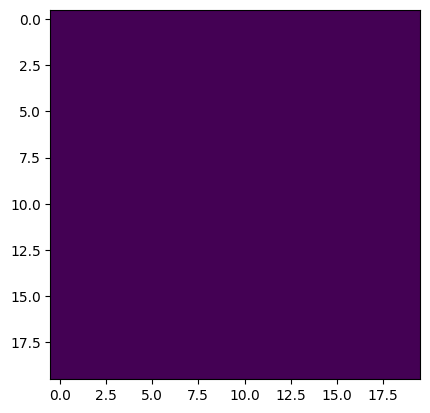

In [6]:
results_dict = {}
approx_ys = np.zeros(1)
time_eval = np.zeros(1)

J_mat = np.array([[0,0,0,0,0],
                  [0,0,1,0,0],
                  [0,1,0,1,0],
                  [0,0,1,0,0],
                  [0,0,0,0,0]])

start_time = time.time()

np.random.seed(0)
sq_sim = IsingSim(N = 20, J_mat = J_mat, T = 0.7, save_trajectories=True, eqSteps = 50, mcSteps = 50)  # Intializing the object
sq_sim.performIsingSim()   # Running the sim
end_time = time.time()
time_eval = end_time-start_time

results_dict[0] = {'sim': sq_sim.results,}
approx_ys[0] = results_dict[0]['sim']['SpecificHeat']
plt.imshow(results_dict[0]['sim']['config'][-1])
plt.show()

Problem 5: What ground states do we get if:
- The NN interactions are 1
- The NN interctions are -1
- 2 of the NN are 1 and 2 are -1?
- Experiment with the NNN interactions, e.g. use the matrix as
                ([[0,0,0,0,0],
                  [0,A,B,A,0],
                  [0,B,0,B,0],
                  [0,A,B,A,0],
                  [0,0,0,0,0]])
and experiment what happens for different combinations on signs of A and B.

Answer 5:

## Evaluation

The code below allows to run the Ising model code for a range of parameters.
- Choose your own values of parameters (for the time being, code is set to change only NN interactions, but please choose other elements of J's matrix to be non-zero)
- If you feel adventurous, experiment with the 2D parameter spaces (i.e. explore behavior as a fucntion of 2 of the exchange integrals)

In [7]:
lb = 0
ub = 3
N_total = 201

#bounds = np.array((lb, ub), dtype=float)
xs = np.linspace(lb, ub, N_total)

Full grid evaluation for 20x20 1D Ising model - Square Model

Recommended parameters:
- 20x20 field
- 300 steps for equilibration
- 300 steps for computation

However, if you are impatient, run (10x10, 50, 50) for quick checks.

Evaluation 1 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 254.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 106.61it/s]


Completed. Saving
Time (s) to complete simulation 1: 0.6832518577575684


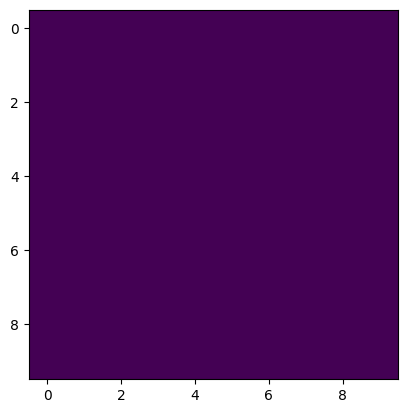

Evaluation 2 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.08it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 72.96it/s]


Completed. Saving
Time (s) to complete simulation 2: 0.9281895160675049


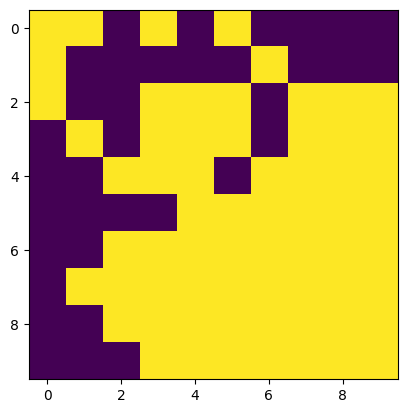

Evaluation 3 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 139.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 58.72it/s]


Completed. Saving
Time (s) to complete simulation 3: 1.2384788990020752


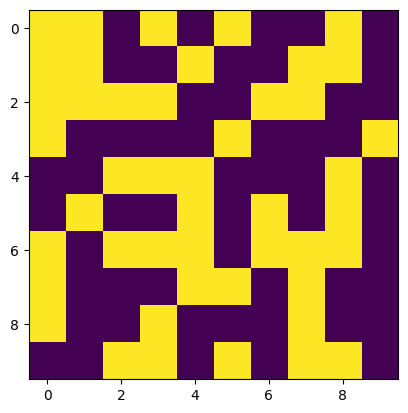

Evaluation 4 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 138.76it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.22it/s]


Completed. Saving
Time (s) to complete simulation 4: 0.966202974319458


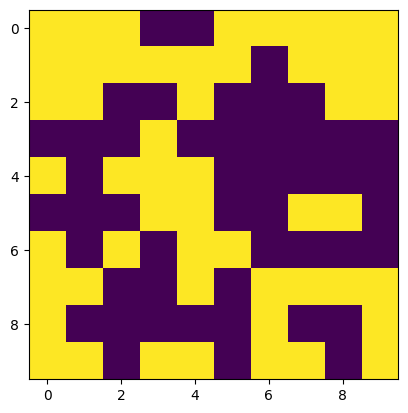

Evaluation 5 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 262.65it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 95.56it/s]


Completed. Saving
Time (s) to complete simulation 5: 0.731501579284668


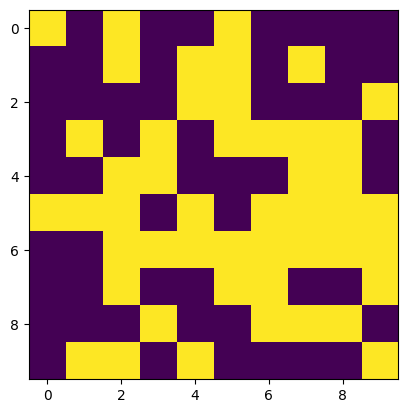

Evaluation 6 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 264.22it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 99.28it/s]


Completed. Saving
Time (s) to complete simulation 6: 0.7155537605285645


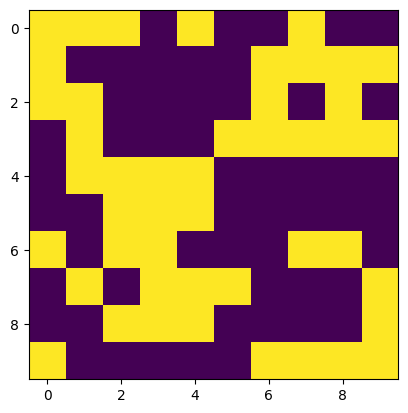

Evaluation 7 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 270.74it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.08it/s]


Completed. Saving
Time (s) to complete simulation 7: 1.202164888381958


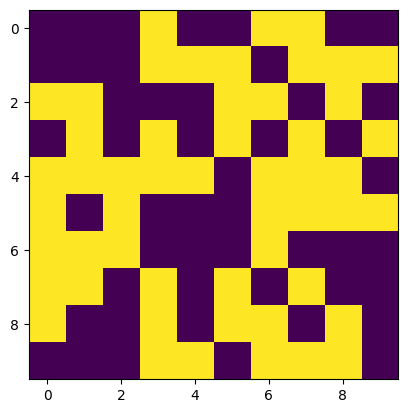

Evaluation 8 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 106.88it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 28.61it/s]


Completed. Saving
Time (s) to complete simulation 8: 2.2610960006713867


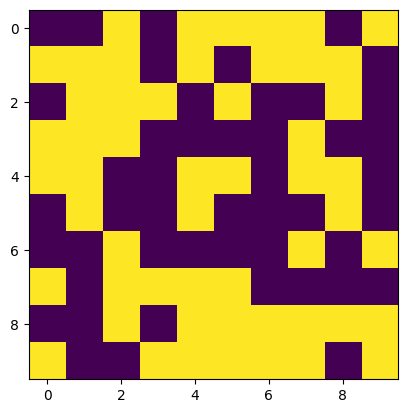

Evaluation 9 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 129.23it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 100.92it/s]


Completed. Saving
Time (s) to complete simulation 9: 0.906400203704834


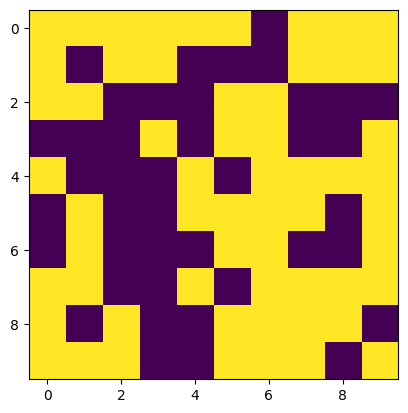

Evaluation 10 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 236.94it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 101.23it/s]


Completed. Saving
Time (s) to complete simulation 10: 0.7294576168060303


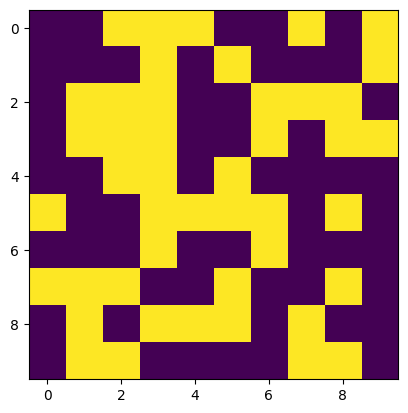

Evaluation 11 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 251.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 101.41it/s]


Completed. Saving
Time (s) to complete simulation 11: 0.7087798118591309


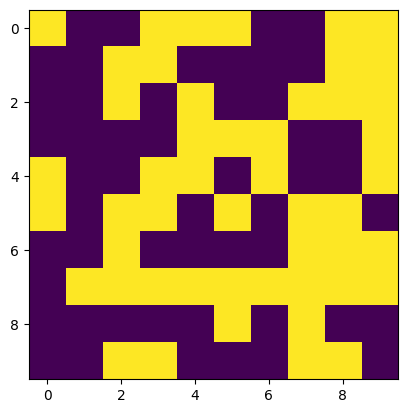

Evaluation 12 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 255.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.89it/s]


Completed. Saving
Time (s) to complete simulation 12: 0.8474199771881104


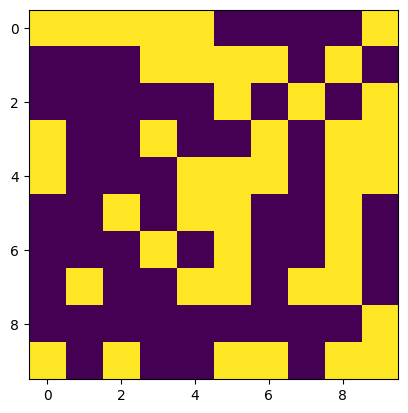

Evaluation 13 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 143.98it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.07it/s]


Completed. Saving
Time (s) to complete simulation 13: 1.2458949089050293


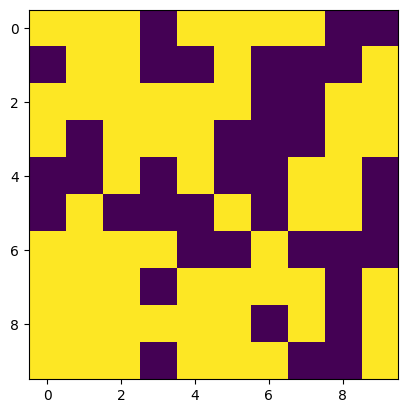

Evaluation 14 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 147.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 63.82it/s]


Completed. Saving
Time (s) to complete simulation 14: 1.1443455219268799


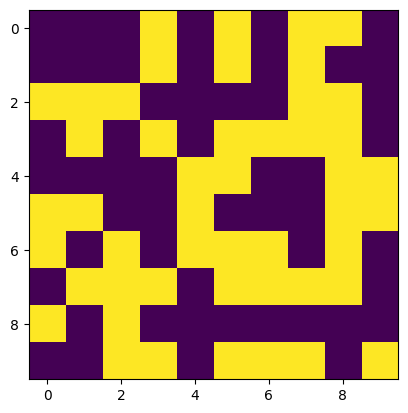

Evaluation 15 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 269.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 99.80it/s] 


Completed. Saving
Time (s) to complete simulation 15: 0.7070426940917969


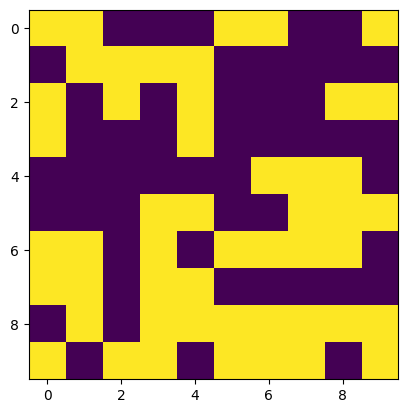

Evaluation 16 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 247.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 98.33it/s] 


Completed. Saving
Time (s) to complete simulation 16: 0.7270369529724121


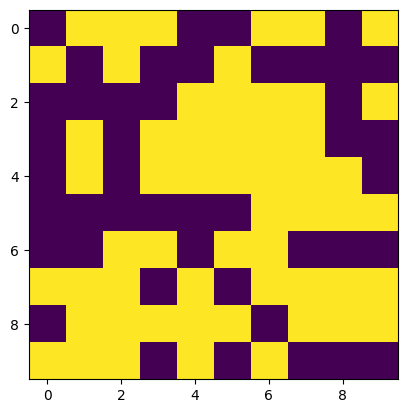

Evaluation 17 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 250.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 102.47it/s]


Completed. Saving
Time (s) to complete simulation 17: 0.7049367427825928


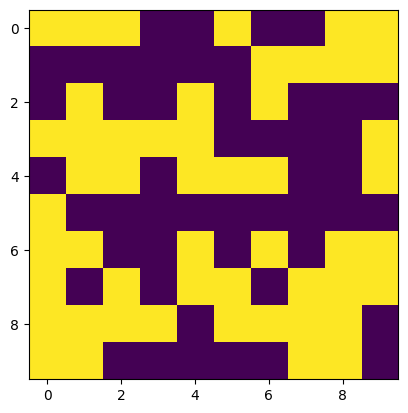

Evaluation 18 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 221.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 100.82it/s]


Completed. Saving
Time (s) to complete simulation 18: 0.7412736415863037


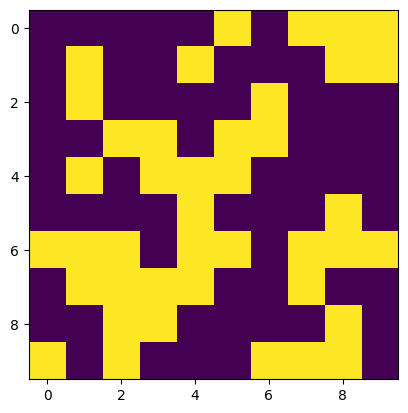

Evaluation 19 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 232.50it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 101.24it/s]


Completed. Saving
Time (s) to complete simulation 19: 0.7387423515319824


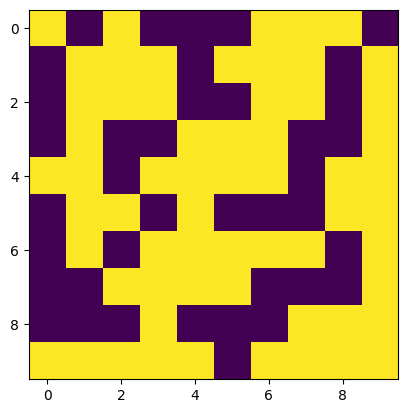

Evaluation 20 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 265.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 94.95it/s]


Completed. Saving
Time (s) to complete simulation 20: 0.736238956451416


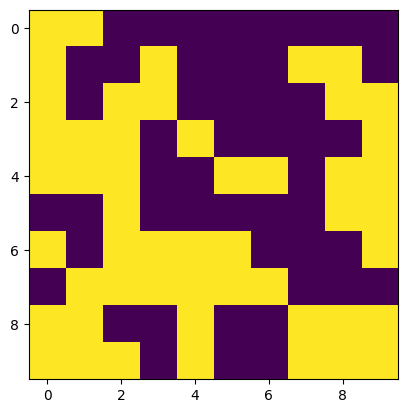

Evaluation 21 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 263.12it/s]


---Finished...
----Performing MC Moves----


100%|██████████| 50/50 [00:00<00:00, 97.44it/s]


Completed. Saving
Time (s) to complete simulation 21: 0.7343564033508301


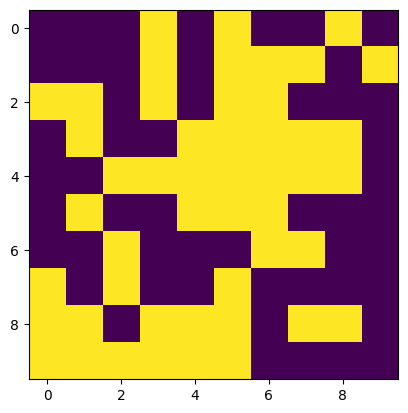

Evaluation 22 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 254.44it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.66it/s]


Completed. Saving
Time (s) to complete simulation 22: 0.729935884475708


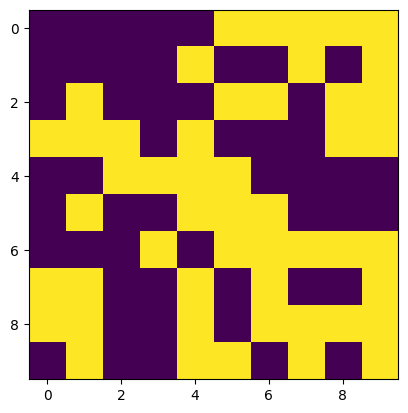

Evaluation 23 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 268.83it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 99.72it/s]


Completed. Saving
Time (s) to complete simulation 23: 0.705996036529541


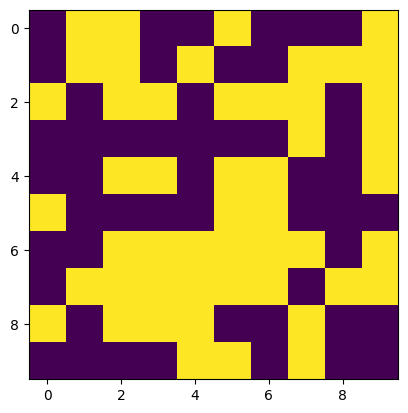

Evaluation 24 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 219.21it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 101.84it/s]


Completed. Saving
Time (s) to complete simulation 24: 0.7393171787261963


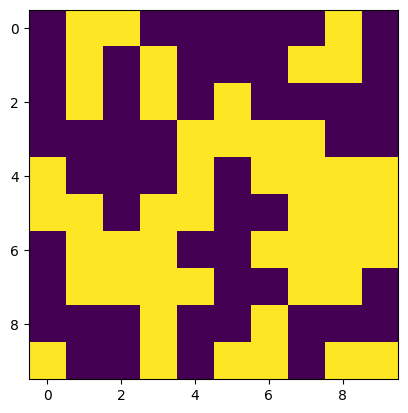

Evaluation 25 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 229.35it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 101.42it/s]


Completed. Saving
Time (s) to complete simulation 25: 0.7329864501953125


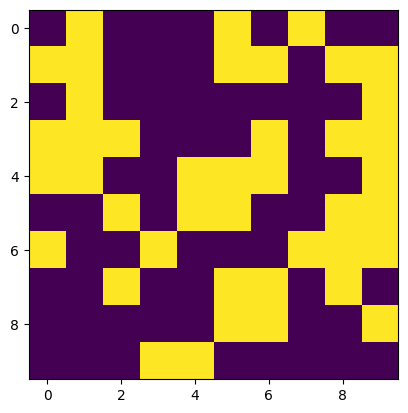

Evaluation 26 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 139.23it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 54.50it/s]


Completed. Saving
Time (s) to complete simulation 26: 1.2999908924102783


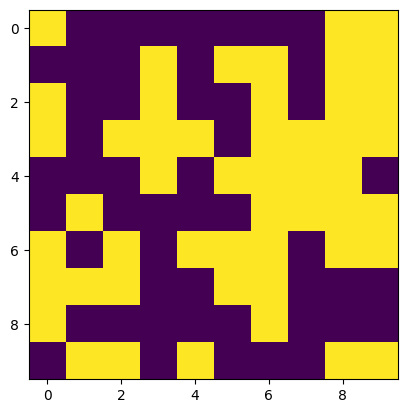

Evaluation 27 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 140.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 48.80it/s]


Completed. Saving
Time (s) to complete simulation 27: 1.4079585075378418


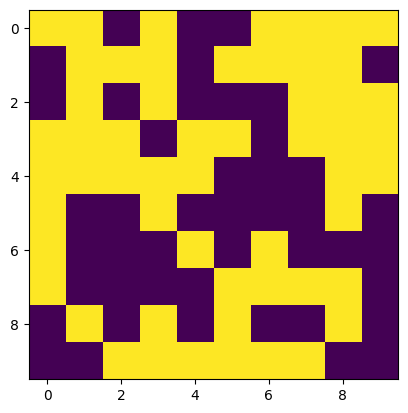

Evaluation 28 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 122.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 48.05it/s]


Completed. Saving
Time (s) to complete simulation 28: 1.4716193675994873


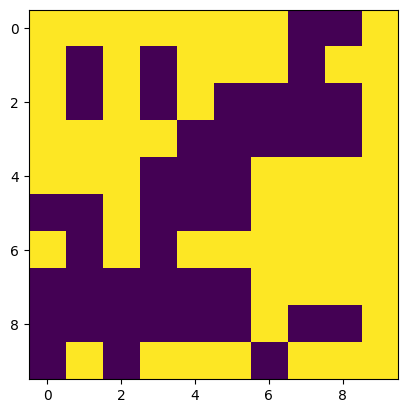

Evaluation 29 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 142.74it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 70.53it/s]


Completed. Saving
Time (s) to complete simulation 29: 1.0776667594909668


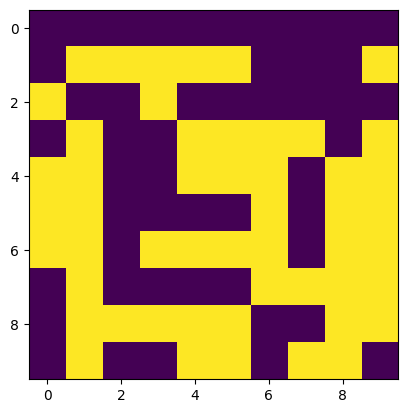

Evaluation 30 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 257.12it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 97.36it/s]


Completed. Saving
Time (s) to complete simulation 30: 0.7283105850219727


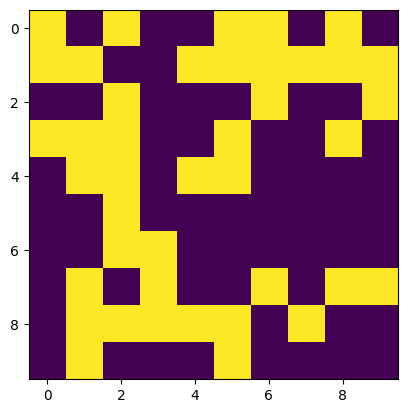

Evaluation 31 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 266.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 101.69it/s]


Completed. Saving
Time (s) to complete simulation 31: 0.6945610046386719


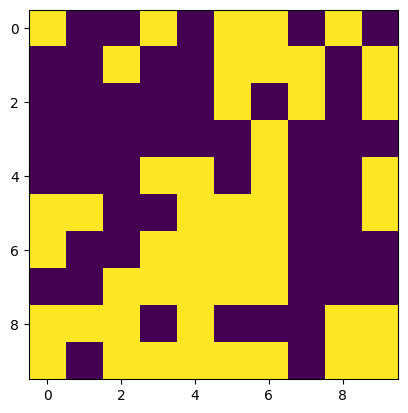

Evaluation 32 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 227.69it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 102.09it/s]


Completed. Saving
Time (s) to complete simulation 32: 0.7302720546722412


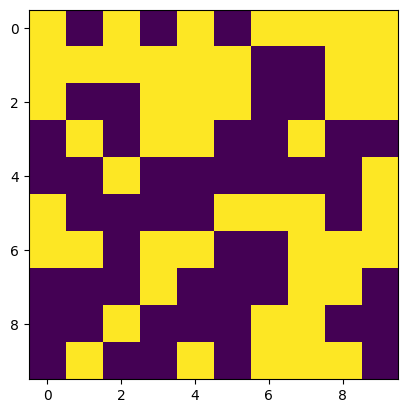

Evaluation 33 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.02it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.56it/s]


Completed. Saving
Time (s) to complete simulation 33: 0.7807743549346924


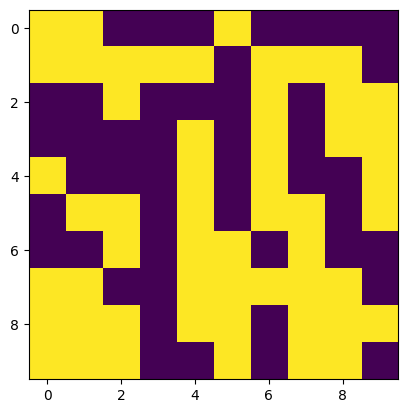

Evaluation 34 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 233.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 94.41it/s]


Completed. Saving
Time (s) to complete simulation 34: 0.7601108551025391


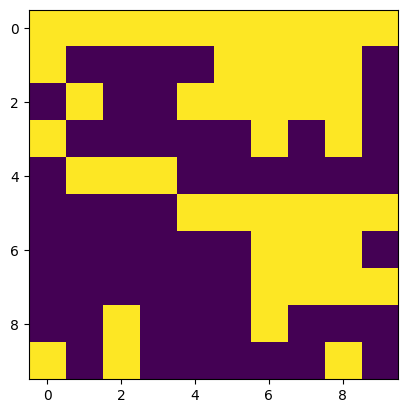

Evaluation 35 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 178.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 54.70it/s]


Completed. Saving
Time (s) to complete simulation 35: 1.2117242813110352


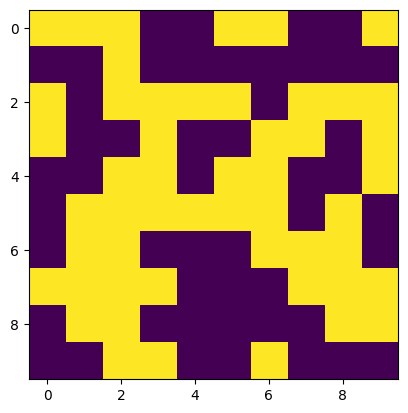

Evaluation 36 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 149.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.74it/s]


Completed. Saving
Time (s) to complete simulation 36: 1.222231149673462


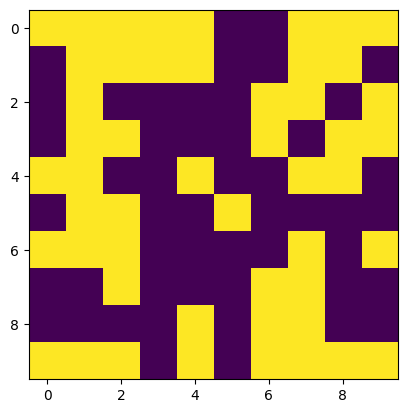

Evaluation 37 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 142.88it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 75.81it/s]


Completed. Saving
Time (s) to complete simulation 37: 1.0360267162322998


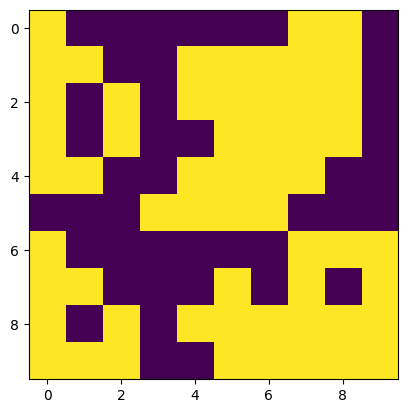

Evaluation 38 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 136.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.10it/s]


Completed. Saving
Time (s) to complete simulation 38: 1.261885404586792


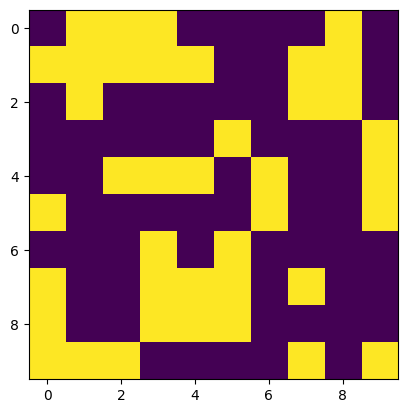

Evaluation 39 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 144.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 56.36it/s]


Completed. Saving
Time (s) to complete simulation 39: 1.2535150051116943


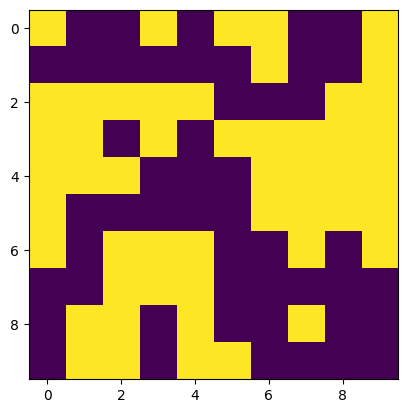

Evaluation 40 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 244.01it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 94.72it/s]


Completed. Saving
Time (s) to complete simulation 40: 0.7579710483551025


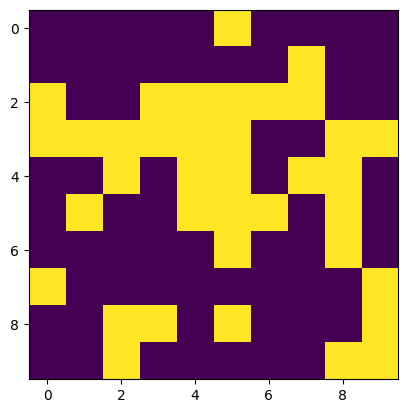

Evaluation 41 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 248.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.49it/s] 


Completed. Saving
Time (s) to complete simulation 41: 0.7363464832305908


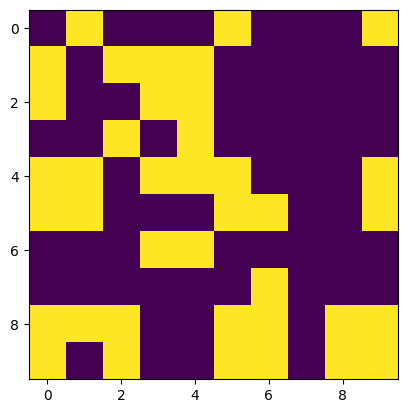

Evaluation 42 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 254.98it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 97.35it/s]


Completed. Saving
Time (s) to complete simulation 42: 0.7345201969146729


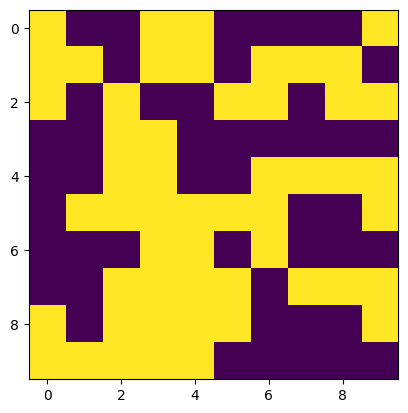

Evaluation 43 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 256.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 98.24it/s]


Completed. Saving
Time (s) to complete simulation 43: 0.7211477756500244


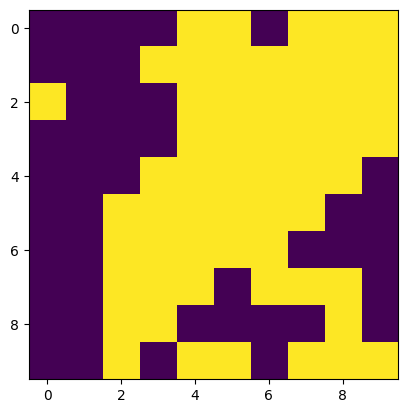

Evaluation 44 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 243.50it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 95.20it/s]


Completed. Saving
Time (s) to complete simulation 44: 0.7500360012054443


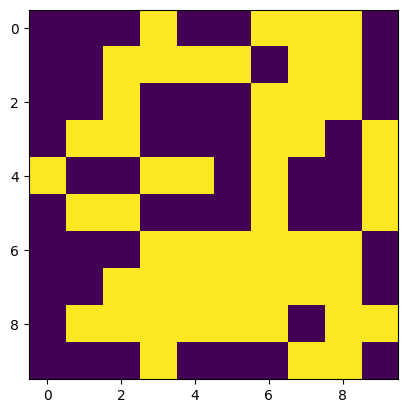

Evaluation 45 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 266.74it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 94.38it/s]


Completed. Saving
Time (s) to complete simulation 45: 0.741513729095459


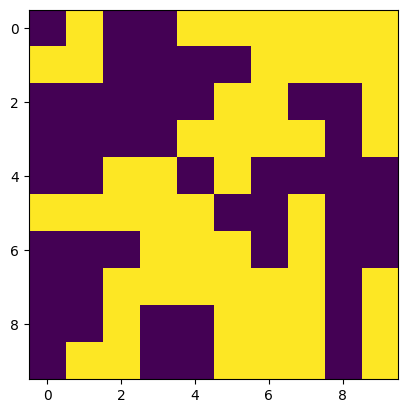

Evaluation 46 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 260.13it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 98.01it/s]


Completed. Saving
Time (s) to complete simulation 46: 0.7213268280029297


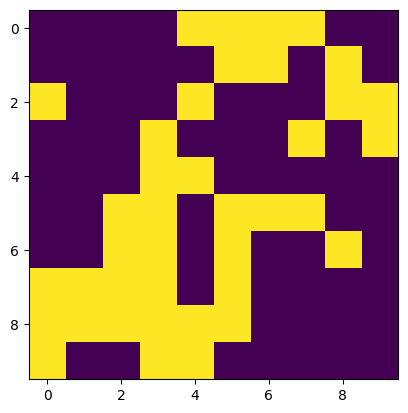

Evaluation 47 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 256.08it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.21it/s]


Completed. Saving
Time (s) to complete simulation 47: 0.7303717136383057


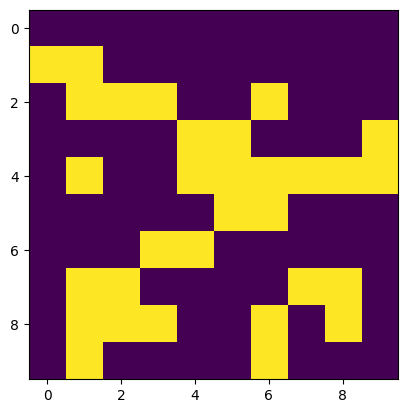

Evaluation 48 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 217.54it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.54it/s] 


Completed. Saving
Time (s) to complete simulation 48: 0.7671685218811035


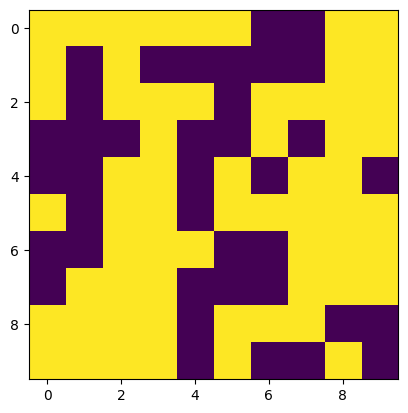

Evaluation 49 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 231.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 97.83it/s]


Completed. Saving
Time (s) to complete simulation 49: 0.7452001571655273


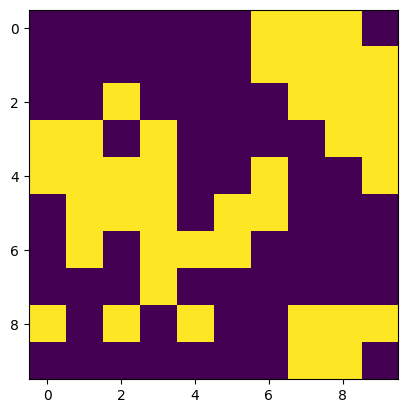

Evaluation 50 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 255.95it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.49it/s]


Completed. Saving
Time (s) to complete simulation 50: 0.8102724552154541


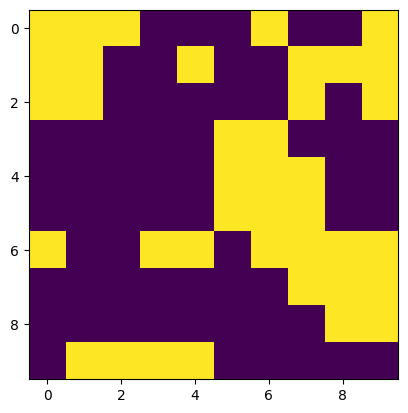

Evaluation 51 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 150.27it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 58.37it/s]


Completed. Saving
Time (s) to complete simulation 51: 1.2061936855316162


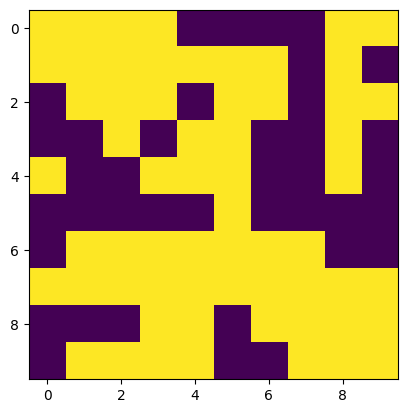

Evaluation 52 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 153.70it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.43it/s]


Completed. Saving
Time (s) to complete simulation 52: 1.218109130859375


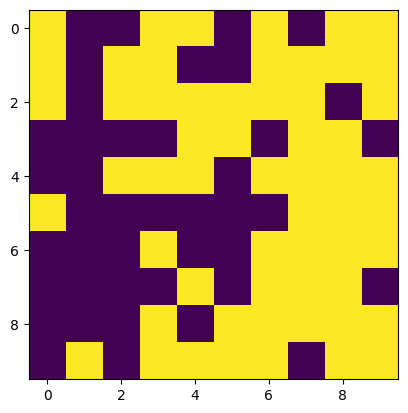

Evaluation 53 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 251.74it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.44it/s]


Completed. Saving
Time (s) to complete simulation 53: 0.7649569511413574


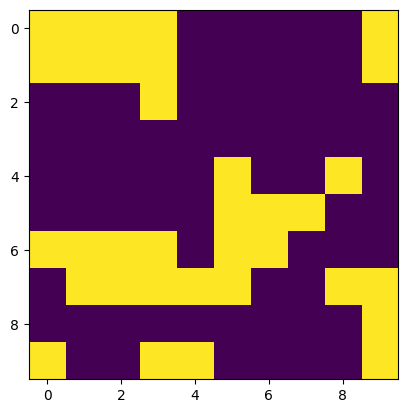

Evaluation 54 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 223.63it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.61it/s]


Completed. Saving
Time (s) to complete simulation 54: 0.7892434597015381


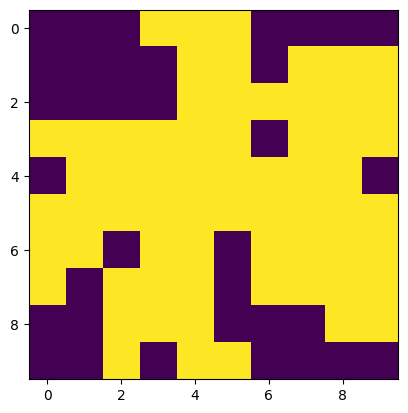

Evaluation 55 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 253.74it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.92it/s]


Completed. Saving
Time (s) to complete simulation 55: 0.7524492740631104


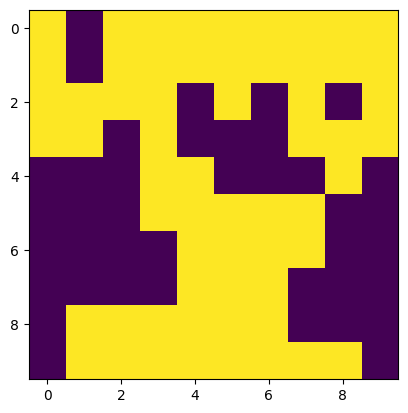

Evaluation 56 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 251.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.18it/s]


Completed. Saving
Time (s) to complete simulation 56: 0.7609057426452637


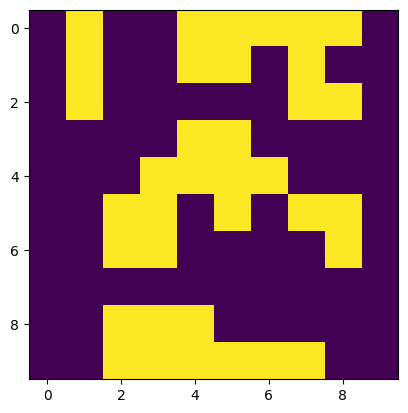

Evaluation 57 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 233.62it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 94.39it/s] 


Completed. Saving
Time (s) to complete simulation 57: 0.7655632495880127


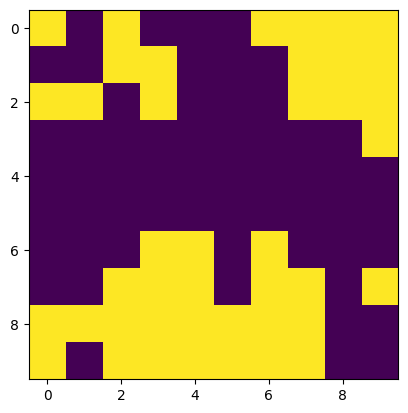

Evaluation 58 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 240.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.28it/s]


Completed. Saving
Time (s) to complete simulation 58: 0.7448182106018066


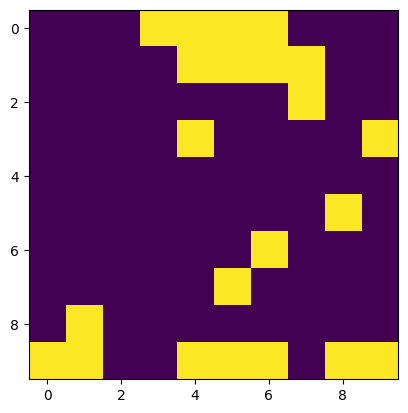

Evaluation 59 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 248.76it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 97.87it/s]


Completed. Saving
Time (s) to complete simulation 59: 0.7342545986175537


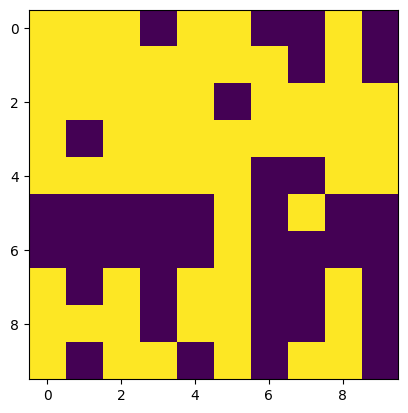

Evaluation 60 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.71it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 98.25it/s] 


Completed. Saving
Time (s) to complete simulation 60: 0.7702634334564209


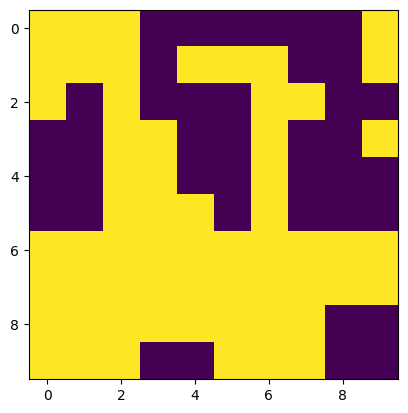

Evaluation 61 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.51it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 95.43it/s]


Completed. Saving
Time (s) to complete simulation 61: 0.7671158313751221


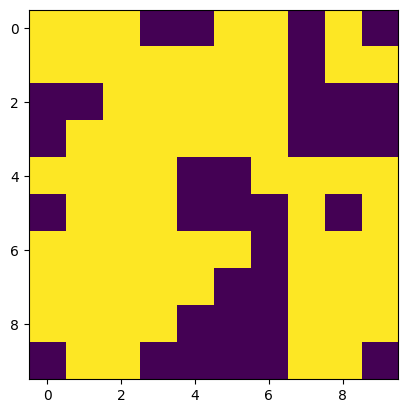

Evaluation 62 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 221.47it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.29it/s]


Completed. Saving
Time (s) to complete simulation 62: 0.78896164894104


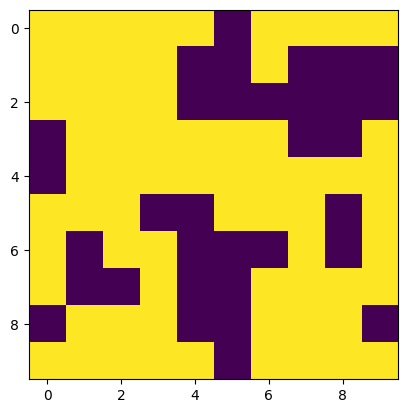

Evaluation 63 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 244.32it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.00it/s]


Completed. Saving
Time (s) to complete simulation 63: 0.7844185829162598


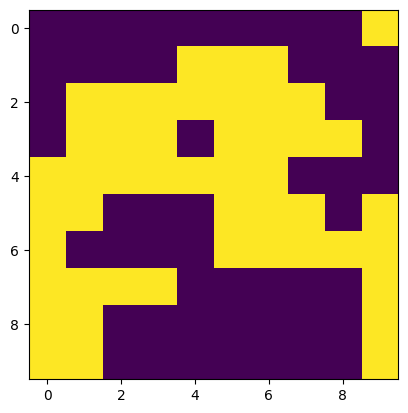

Evaluation 64 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 128.58it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 56.35it/s]


Completed. Saving
Time (s) to complete simulation 64: 1.2982218265533447


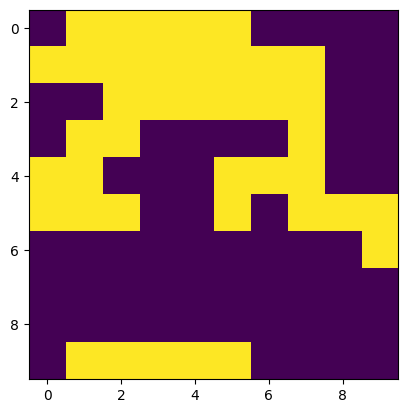

Evaluation 65 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 143.24it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.20it/s]


Completed. Saving
Time (s) to complete simulation 65: 1.2416329383850098


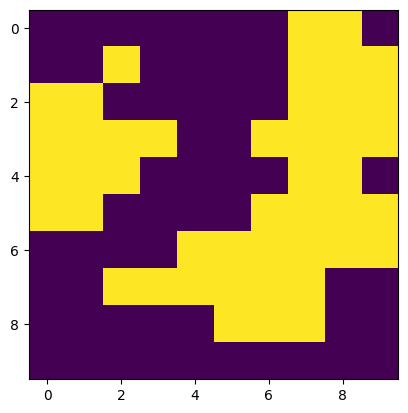

Evaluation 66 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 154.07it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.43it/s]


Completed. Saving
Time (s) to complete simulation 66: 0.8778913021087646


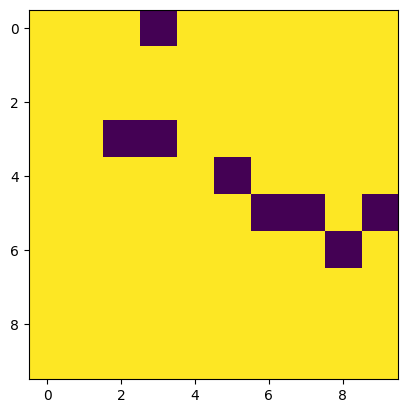

Evaluation 67 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 253.10it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 66.78it/s]


Completed. Saving
Time (s) to complete simulation 67: 0.9638044834136963


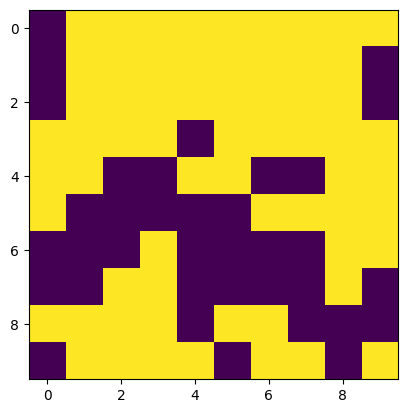

Evaluation 68 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 138.19it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.61it/s]


Completed. Saving
Time (s) to complete simulation 68: 0.918320894241333


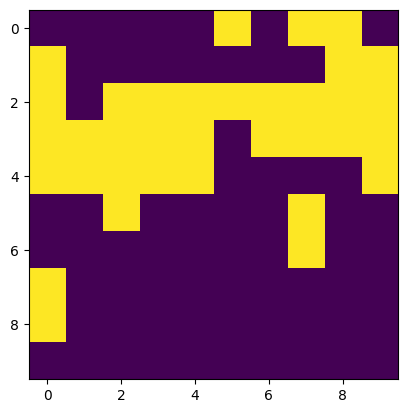

Evaluation 69 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.02it/s] 


Completed. Saving
Time (s) to complete simulation 69: 0.7854795455932617


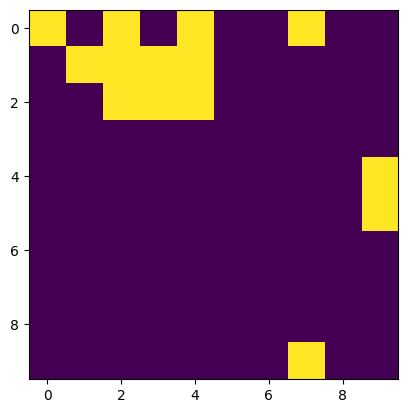

Evaluation 70 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 235.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.80it/s]


Completed. Saving
Time (s) to complete simulation 70: 0.7644305229187012


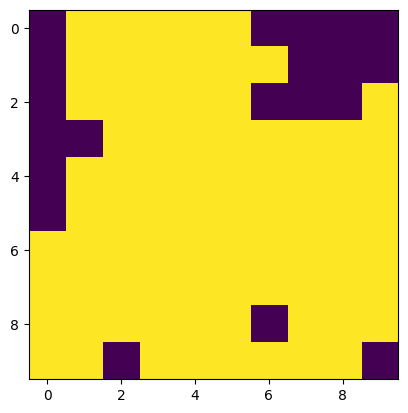

Evaluation 71 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 239.39it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.70it/s]


Completed. Saving
Time (s) to complete simulation 71: 0.7779712677001953


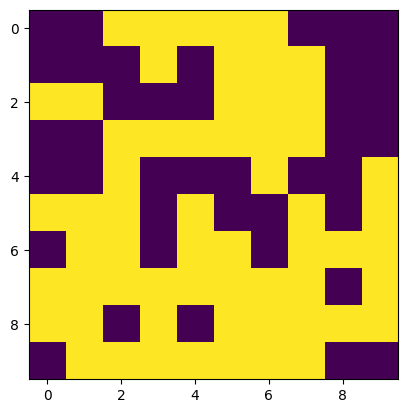

Evaluation 72 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 254.20it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 94.81it/s]


Completed. Saving
Time (s) to complete simulation 72: 0.743034839630127


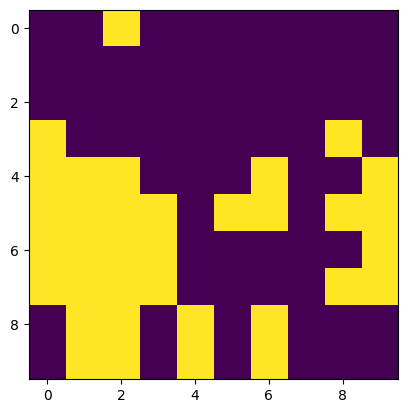

Evaluation 73 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.12it/s]


Completed. Saving
Time (s) to complete simulation 73: 0.8156611919403076


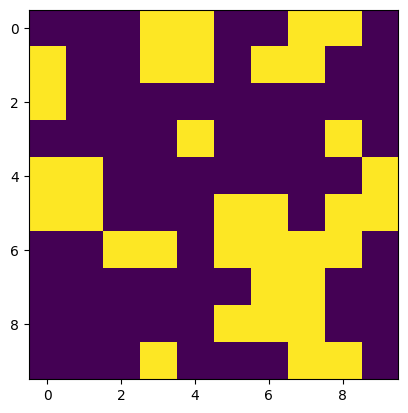

Evaluation 74 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 218.30it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 94.54it/s]


Completed. Saving
Time (s) to complete simulation 74: 0.773421049118042


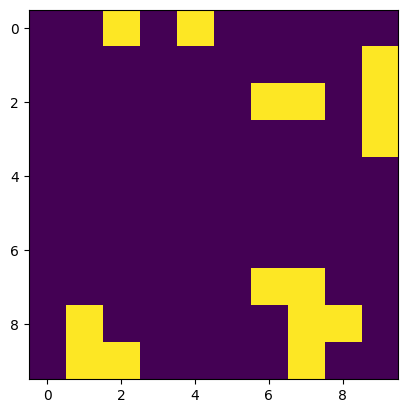

Evaluation 75 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 225.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.51it/s]


Completed. Saving
Time (s) to complete simulation 75: 0.792109489440918


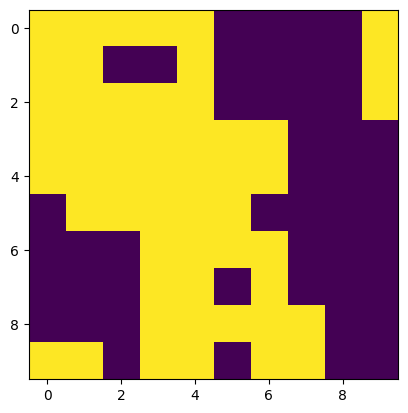

Evaluation 76 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 250.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 74.69it/s]


Completed. Saving
Time (s) to complete simulation 76: 0.9015662670135498


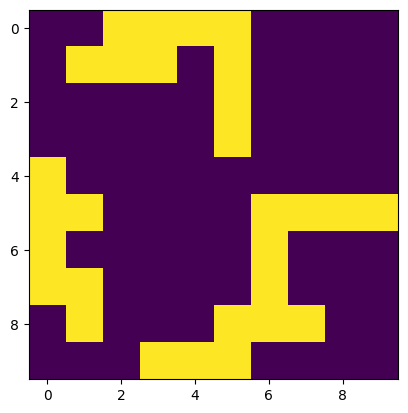

Evaluation 77 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 143.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.42it/s]


Completed. Saving
Time (s) to complete simulation 77: 1.241941213607788


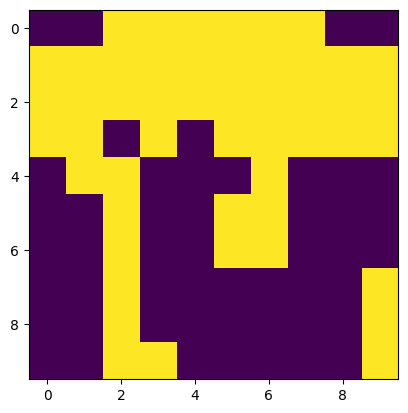

Evaluation 78 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 138.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 53.71it/s]


Completed. Saving
Time (s) to complete simulation 78: 1.3120572566986084


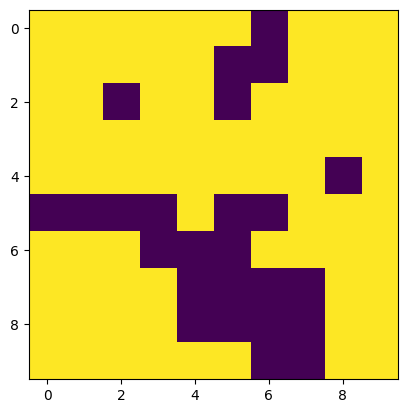

Evaluation 79 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 245.42it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.53it/s]


Completed. Saving
Time (s) to complete simulation 79: 0.7716152667999268


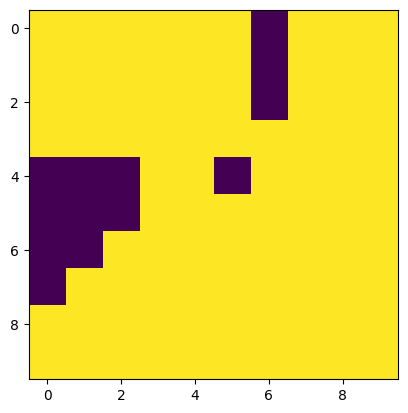

Evaluation 80 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 254.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.51it/s]


Completed. Saving
Time (s) to complete simulation 80: 0.7585439682006836


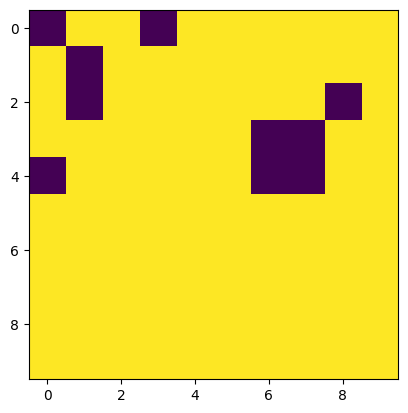

Evaluation 81 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 254.36it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.26it/s]


Completed. Saving
Time (s) to complete simulation 81: 0.7321672439575195


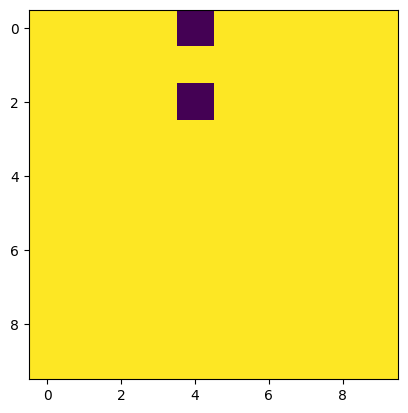

Evaluation 82 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 237.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.02it/s]


Completed. Saving
Time (s) to complete simulation 82: 0.7485556602478027


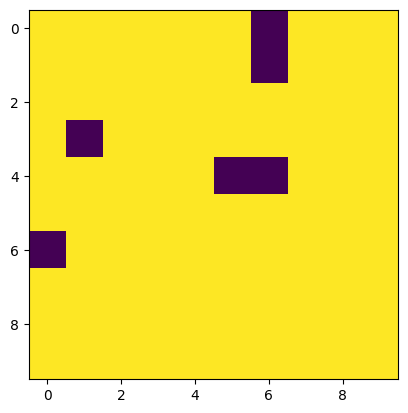

Evaluation 83 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 220.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 97.49it/s]


Completed. Saving
Time (s) to complete simulation 83: 0.754570722579956


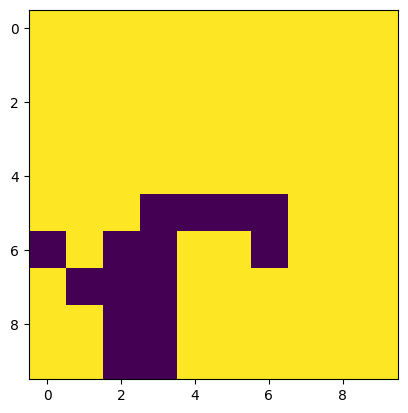

Evaluation 84 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.47it/s]


Completed. Saving
Time (s) to complete simulation 84: 0.7871019840240479


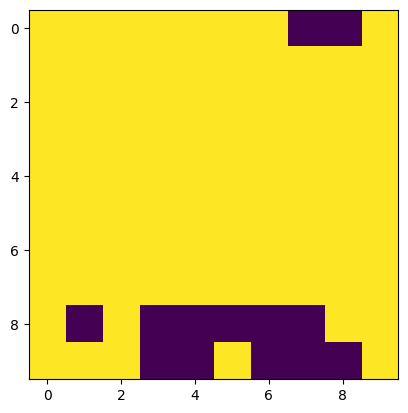

Evaluation 85 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 210.27it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.87it/s]


Completed. Saving
Time (s) to complete simulation 85: 0.8003275394439697


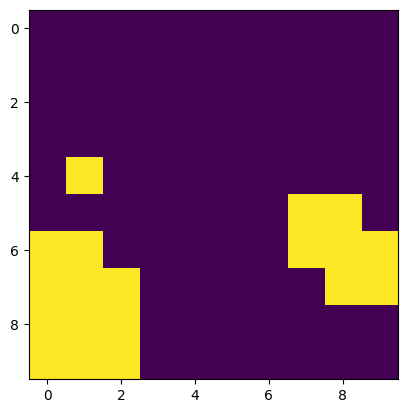

Evaluation 86 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 255.47it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 95.75it/s] 


Completed. Saving
Time (s) to complete simulation 86: 0.7450253963470459


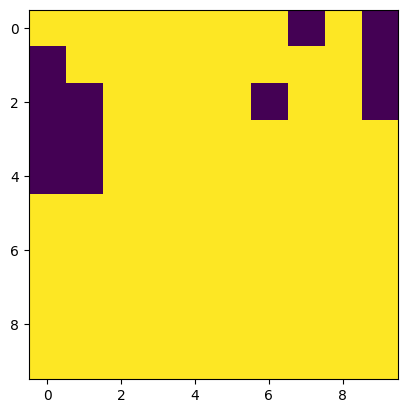

Evaluation 87 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 231.12it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.72it/s]


Completed. Saving
Time (s) to complete simulation 87: 0.7835094928741455


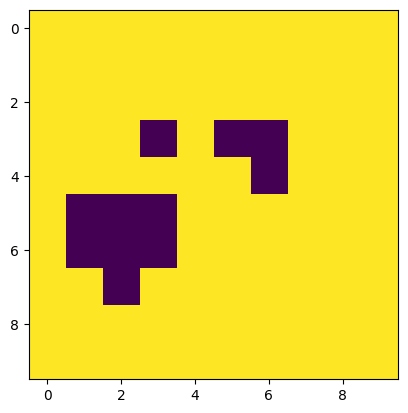

Evaluation 88 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.32it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.31it/s]


Completed. Saving
Time (s) to complete simulation 88: 0.7929356098175049


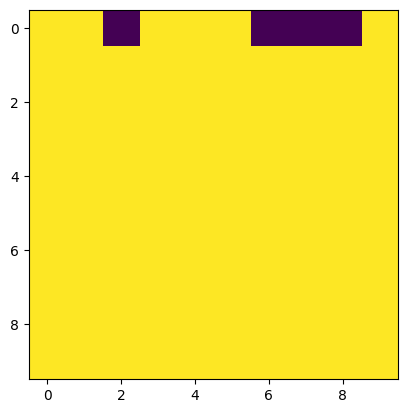

Evaluation 89 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 220.31it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.52it/s]


Completed. Saving
Time (s) to complete simulation 89: 1.1203868389129639


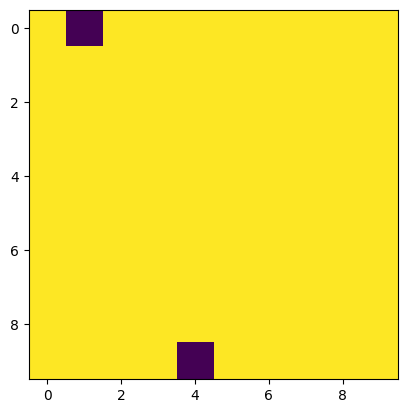

Evaluation 90 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 151.21it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 55.85it/s]


Completed. Saving
Time (s) to complete simulation 90: 1.2472264766693115


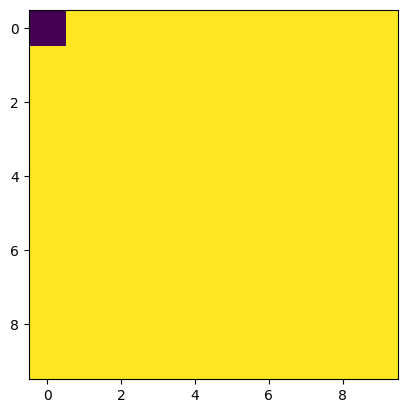

Evaluation 91 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 138.63it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 72.99it/s]


Completed. Saving
Time (s) to complete simulation 91: 1.0592856407165527


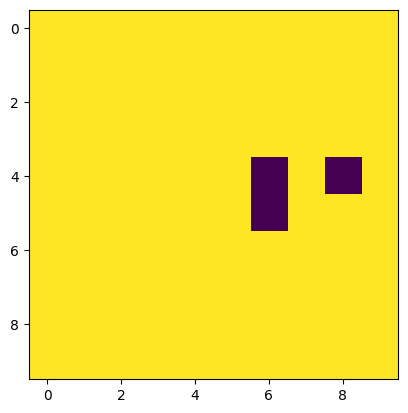

Evaluation 92 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 230.02it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.57it/s]


Completed. Saving
Time (s) to complete simulation 92: 0.7810230255126953


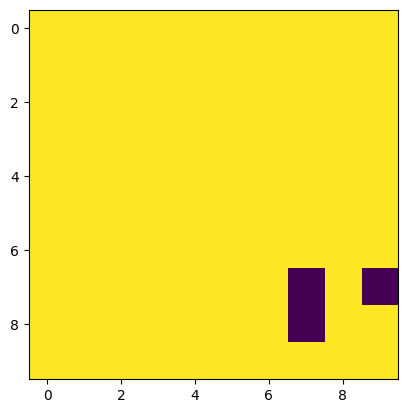

Evaluation 93 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 95.40it/s]


Completed. Saving
Time (s) to complete simulation 93: 0.7770283222198486


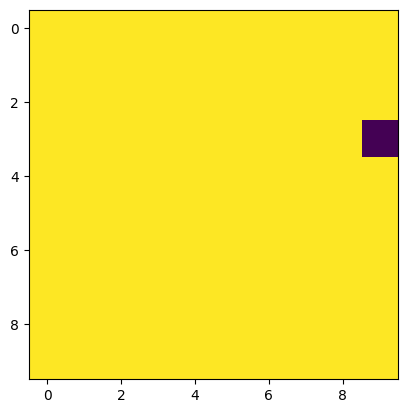

Evaluation 94 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.59it/s]


Completed. Saving
Time (s) to complete simulation 94: 0.7720565795898438


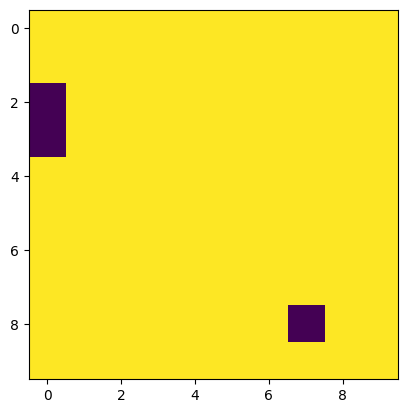

Evaluation 95 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.94it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.47it/s]


Completed. Saving
Time (s) to complete simulation 95: 0.8014369010925293


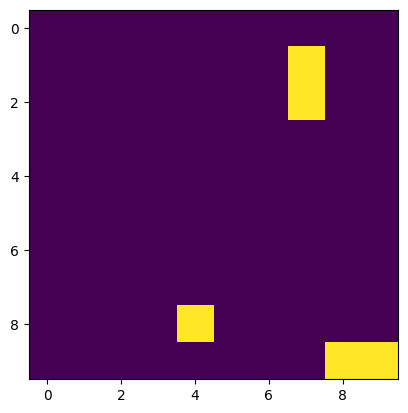

Evaluation 96 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.39it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.92it/s]


Completed. Saving
Time (s) to complete simulation 96: 0.8138942718505859


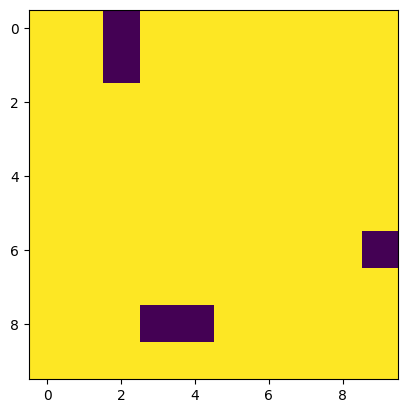

Evaluation 97 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 216.77it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.49it/s]


Completed. Saving
Time (s) to complete simulation 97: 0.806307315826416


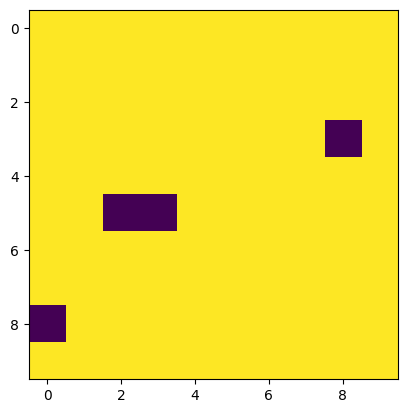

Evaluation 98 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 242.95it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.61it/s]


Completed. Saving
Time (s) to complete simulation 98: 0.7960577011108398


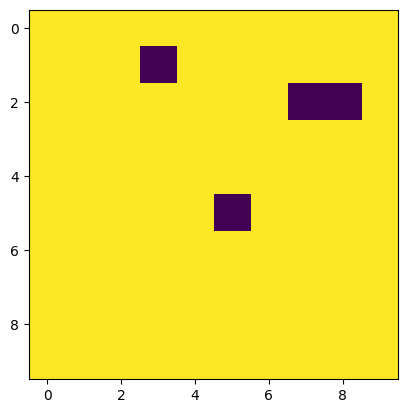

Evaluation 99 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 233.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.43it/s]


Completed. Saving
Time (s) to complete simulation 99: 0.8197720050811768


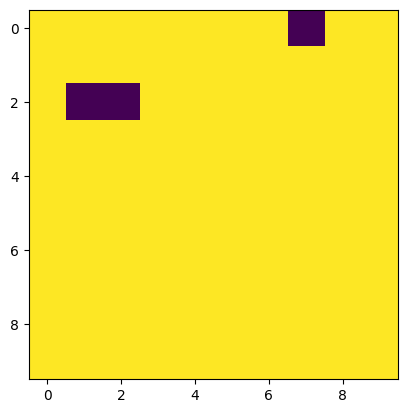

Evaluation 100 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 219.35it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.91it/s]


Completed. Saving
Time (s) to complete simulation 100: 0.8394098281860352


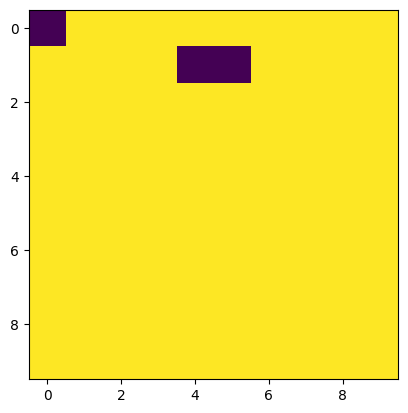

Evaluation 101 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 227.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.10it/s]


Completed. Saving
Time (s) to complete simulation 101: 0.8191003799438477


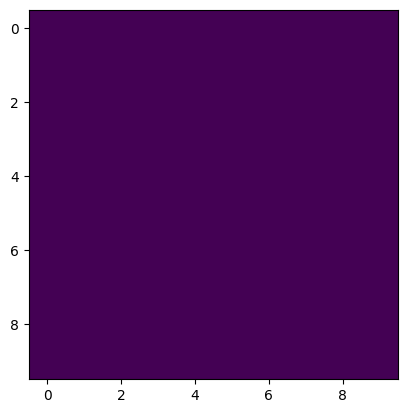

Evaluation 102 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 142.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 55.30it/s]


Completed. Saving
Time (s) to complete simulation 102: 1.2784006595611572


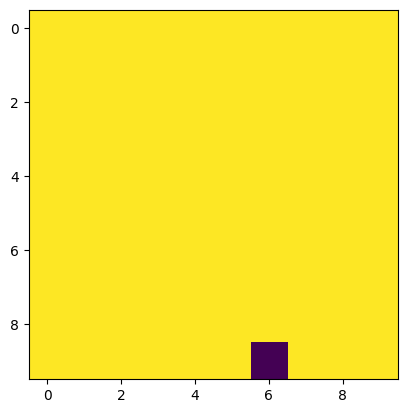

Evaluation 103 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 144.44it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 59.98it/s]


Completed. Saving
Time (s) to complete simulation 103: 1.2004857063293457


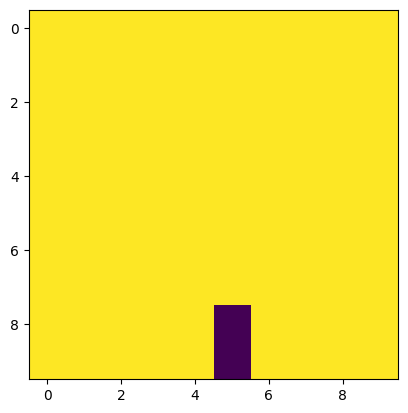

Evaluation 104 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 154.10it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 72.55it/s]


Completed. Saving
Time (s) to complete simulation 104: 1.0335471630096436


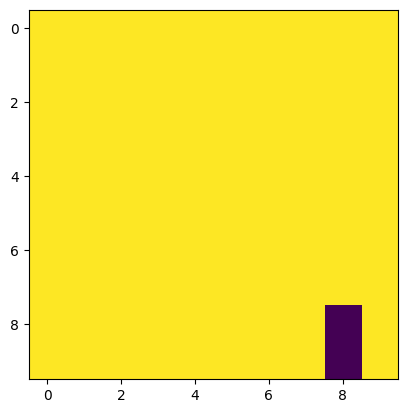

Evaluation 105 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 235.32it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.52it/s]


Completed. Saving
Time (s) to complete simulation 105: 0.7990083694458008


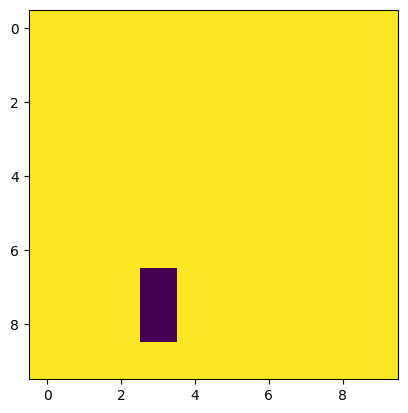

Evaluation 106 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 220.49it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.47it/s]


Completed. Saving
Time (s) to complete simulation 106: 0.8148198127746582


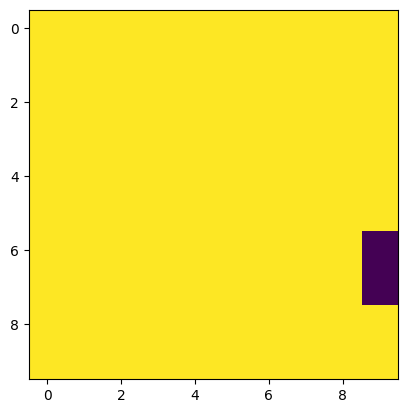

Evaluation 107 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 219.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.52it/s]


Completed. Saving
Time (s) to complete simulation 107: 0.809828519821167


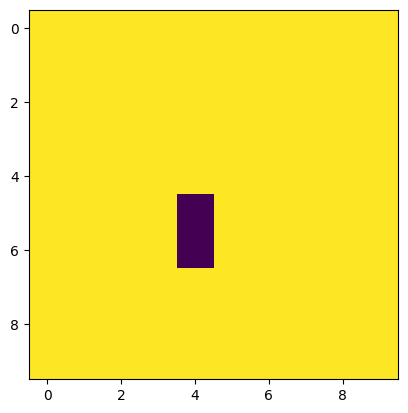

Evaluation 108 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.64it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.43it/s]


Completed. Saving
Time (s) to complete simulation 108: 0.7992949485778809


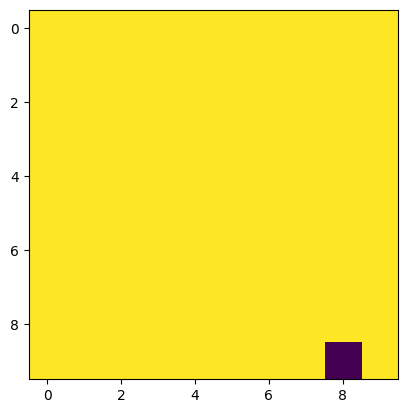

Evaluation 109 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.63it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.79it/s]


Completed. Saving
Time (s) to complete simulation 109: 0.8299005031585693


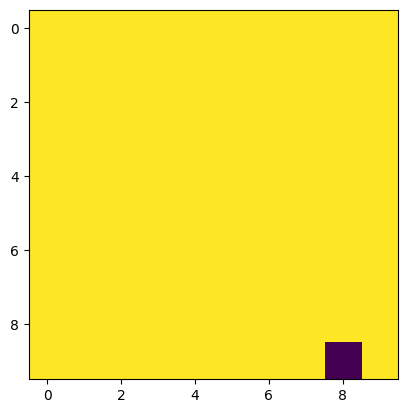

Evaluation 110 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.38it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.05it/s]


Completed. Saving
Time (s) to complete simulation 110: 0.8282287120819092


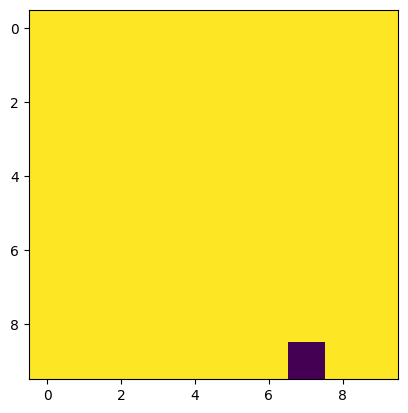

Evaluation 111 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.77it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.29it/s]


Completed. Saving
Time (s) to complete simulation 111: 0.8233532905578613


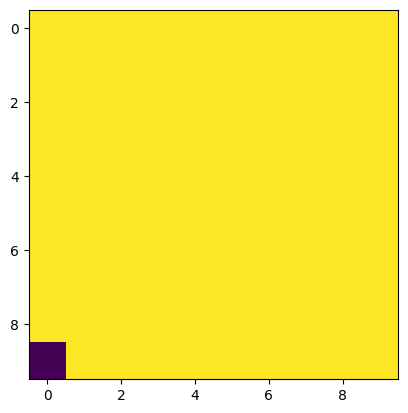

Evaluation 112 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.26it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.91it/s]


Completed. Saving
Time (s) to complete simulation 112: 0.8070507049560547


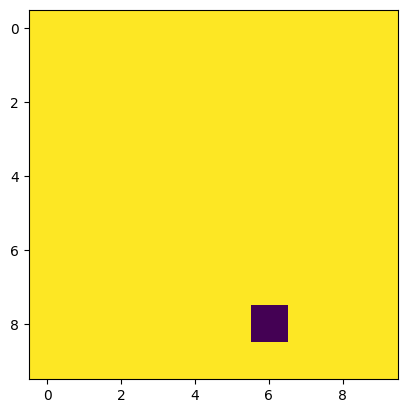

Evaluation 113 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.99it/s]


Completed. Saving
Time (s) to complete simulation 113: 0.8163158893585205


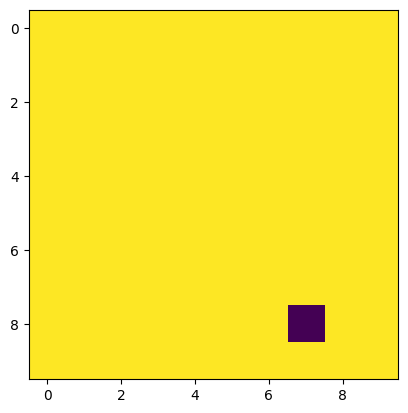

Evaluation 114 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 225.25it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.34it/s]


Completed. Saving
Time (s) to complete simulation 114: 0.8459627628326416


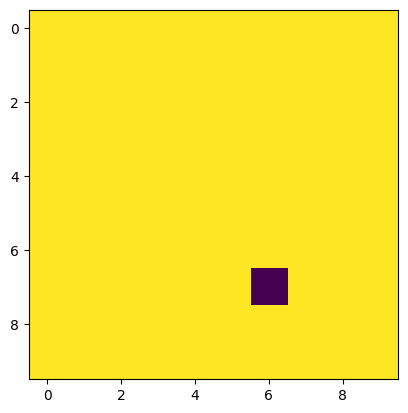

Evaluation 115 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 140.61it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 56.23it/s]


Completed. Saving
Time (s) to complete simulation 115: 1.2688446044921875


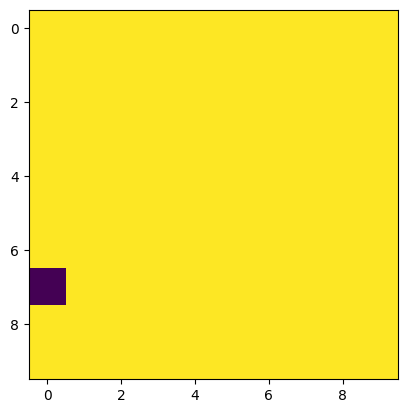

Evaluation 116 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 166.25it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 53.82it/s]


Completed. Saving
Time (s) to complete simulation 116: 1.2557590007781982


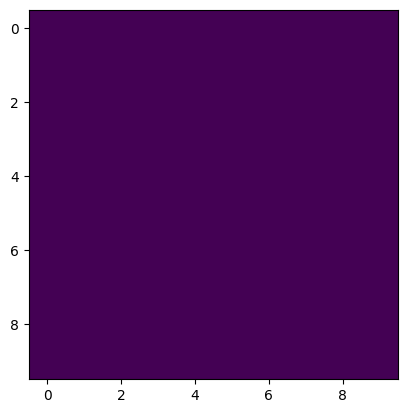

Evaluation 117 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 161.55it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.67it/s]


Completed. Saving
Time (s) to complete simulation 117: 0.9256694316864014


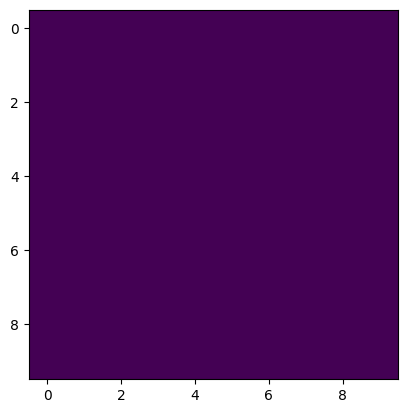

Evaluation 118 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 220.27it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.20it/s]


Completed. Saving
Time (s) to complete simulation 118: 0.8205513954162598


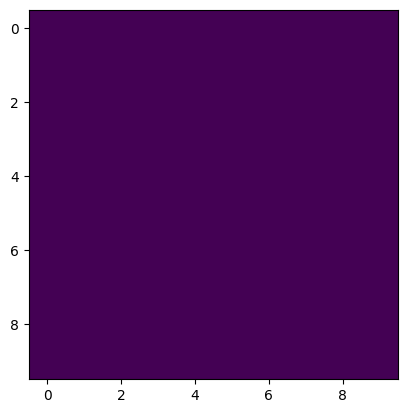

Evaluation 119 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 226.71it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.05it/s]


Completed. Saving
Time (s) to complete simulation 119: 0.8026351928710938


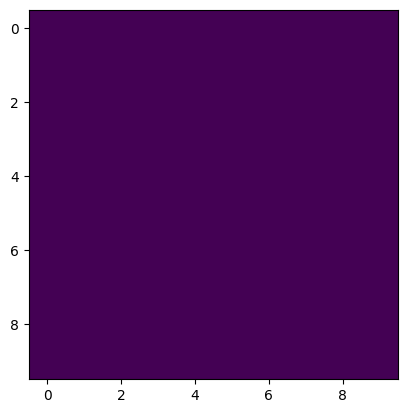

Evaluation 120 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 223.06it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.09it/s]


Completed. Saving
Time (s) to complete simulation 120: 0.834604024887085


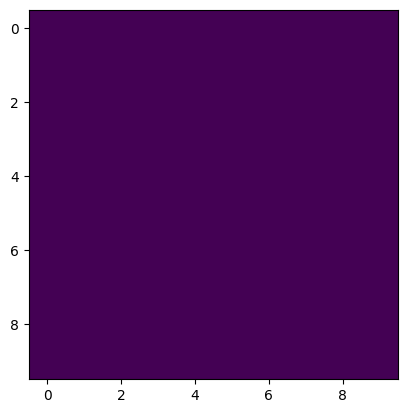

Evaluation 121 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.92it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.25it/s]


Completed. Saving
Time (s) to complete simulation 121: 0.8208041191101074


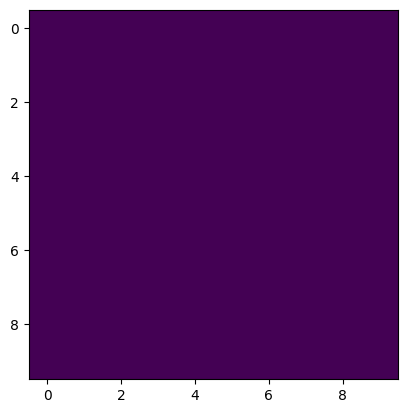

Evaluation 122 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.01it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.25it/s]


Completed. Saving
Time (s) to complete simulation 122: 0.8392505645751953


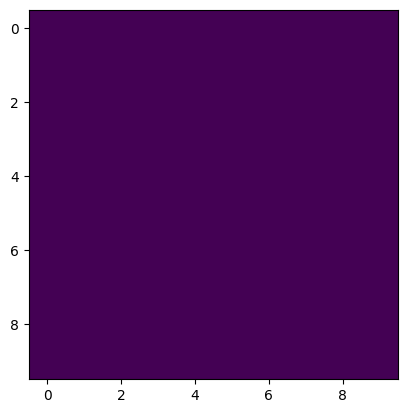

Evaluation 123 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.28it/s]


Completed. Saving
Time (s) to complete simulation 123: 0.8125782012939453


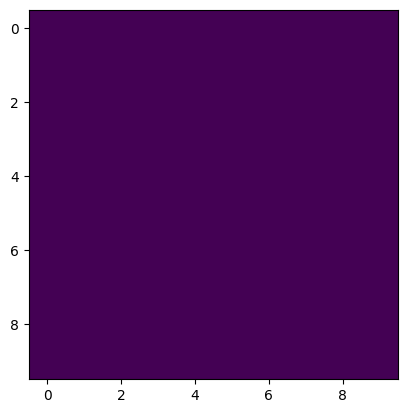

Evaluation 124 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 223.73it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.78it/s]


Completed. Saving
Time (s) to complete simulation 124: 0.8309612274169922


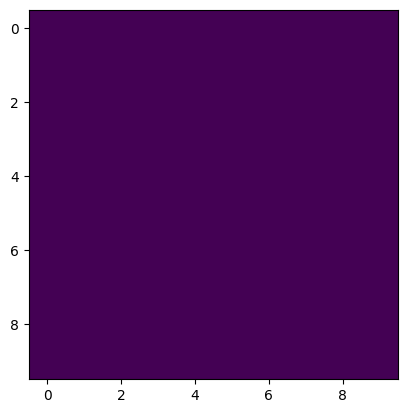

Evaluation 125 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 216.95it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.33it/s]


Completed. Saving
Time (s) to complete simulation 125: 0.8041210174560547


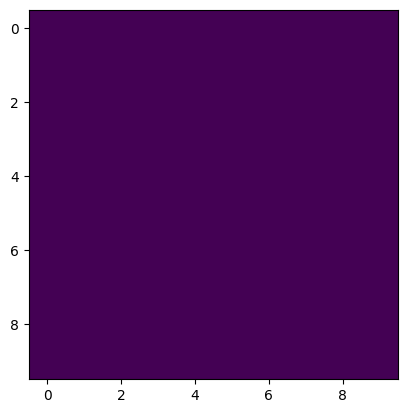

Evaluation 126 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 221.15it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.24it/s]


Completed. Saving
Time (s) to complete simulation 126: 0.80238938331604


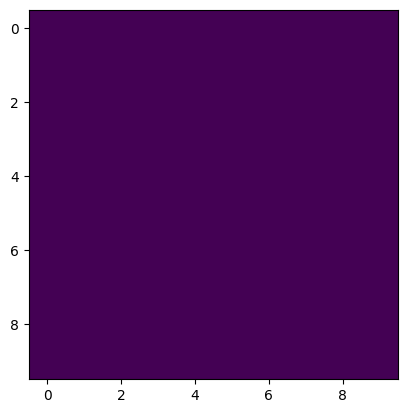

Evaluation 127 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 228.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 56.68it/s]


Completed. Saving
Time (s) to complete simulation 127: 1.1239666938781738


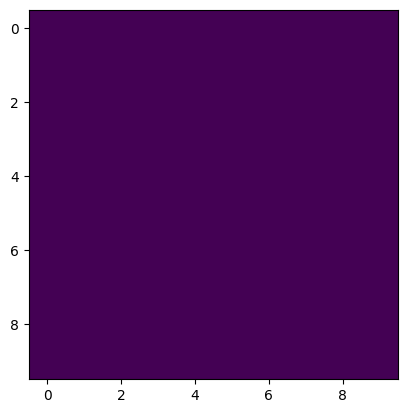

Evaluation 128 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 161.56it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 55.67it/s]


Completed. Saving
Time (s) to complete simulation 128: 1.2257616519927979


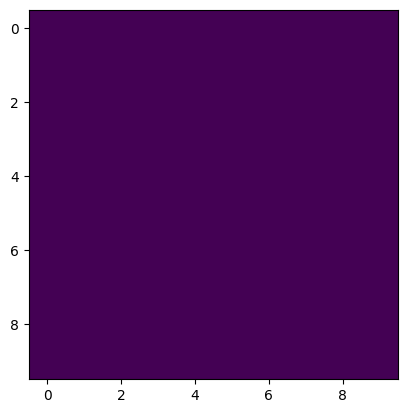

Evaluation 129 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 136.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 59.31it/s]


Completed. Saving
Time (s) to complete simulation 129: 1.2306294441223145


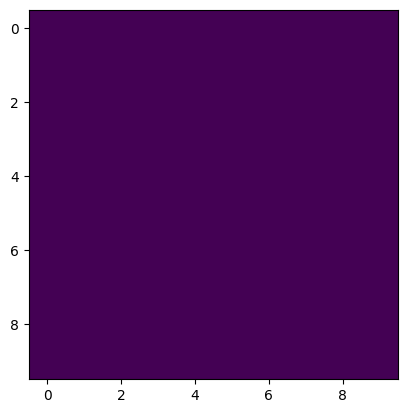

Evaluation 130 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 216.09it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.65it/s]


Completed. Saving
Time (s) to complete simulation 130: 0.8108339309692383


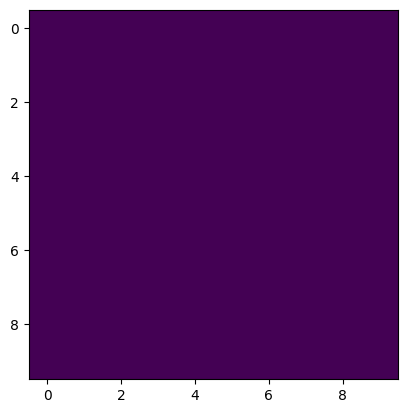

Evaluation 131 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 228.17it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.40it/s]


Completed. Saving
Time (s) to complete simulation 131: 0.7723922729492188


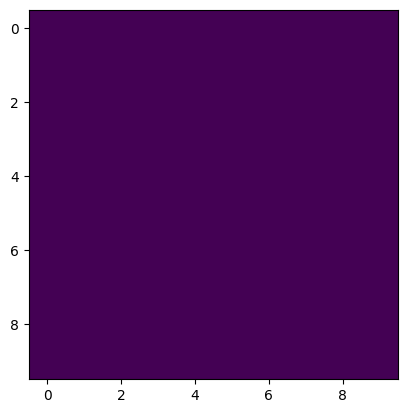

Evaluation 132 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 223.15it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.25it/s]


Completed. Saving
Time (s) to complete simulation 132: 0.8086159229278564


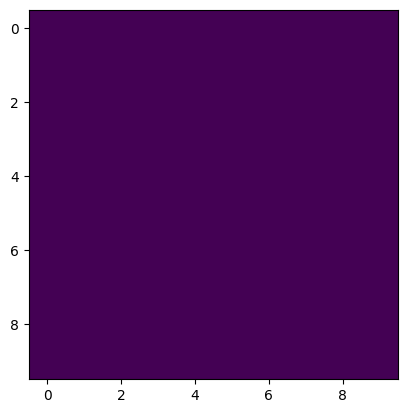

Evaluation 133 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.06it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.06it/s]


Completed. Saving
Time (s) to complete simulation 133: 0.8354473114013672


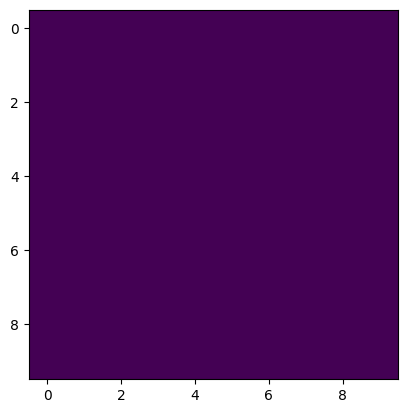

Evaluation 134 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 215.23it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.05it/s]


Completed. Saving
Time (s) to complete simulation 134: 0.8150990009307861


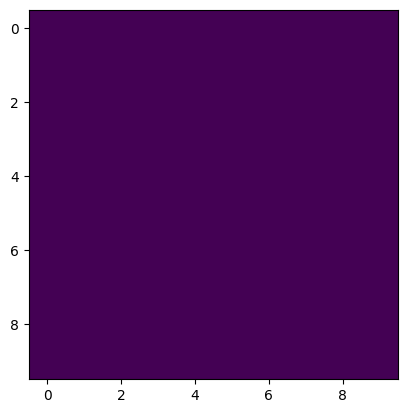

Evaluation 135 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 191.67it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.50it/s]


Completed. Saving
Time (s) to complete simulation 135: 0.8459591865539551


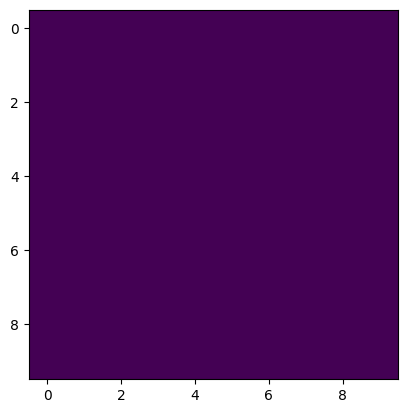

Evaluation 136 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.20it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.43it/s]


Completed. Saving
Time (s) to complete simulation 136: 0.8295989036560059


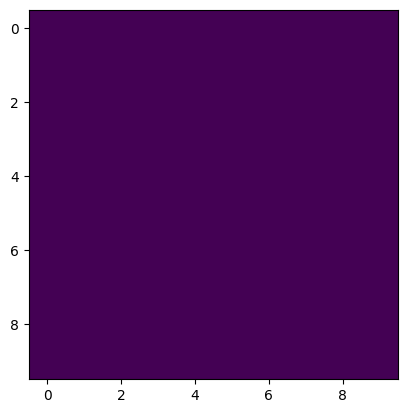

Evaluation 137 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.89it/s]


Completed. Saving
Time (s) to complete simulation 137: 0.8308935165405273


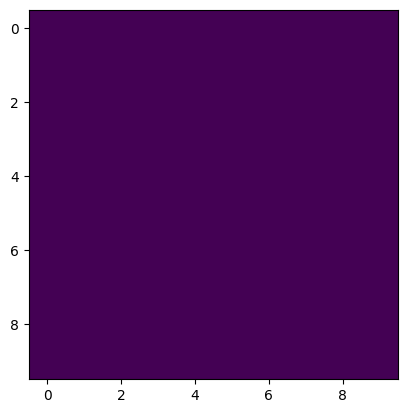

Evaluation 138 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.36it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.36it/s]


Completed. Saving
Time (s) to complete simulation 138: 0.8451681137084961


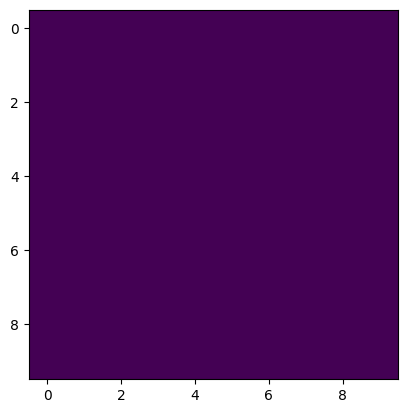

Evaluation 139 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 195.04it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 70.37it/s]


Completed. Saving
Time (s) to complete simulation 139: 0.9876511096954346


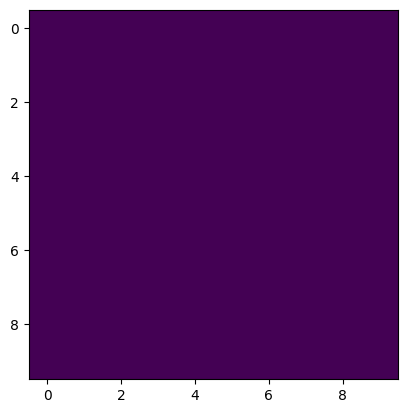

Evaluation 140 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 149.24it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 55.37it/s]


Completed. Saving
Time (s) to complete simulation 140: 1.2626674175262451


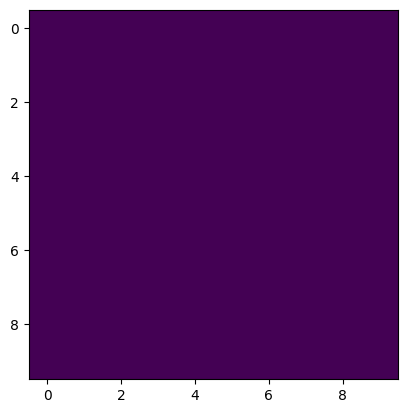

Evaluation 141 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 139.55it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.19it/s]


Completed. Saving
Time (s) to complete simulation 141: 1.2498455047607422


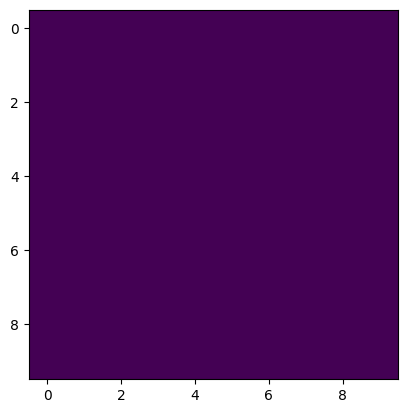

Evaluation 142 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 143.23it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.51it/s]


Completed. Saving
Time (s) to complete simulation 142: 0.949476957321167


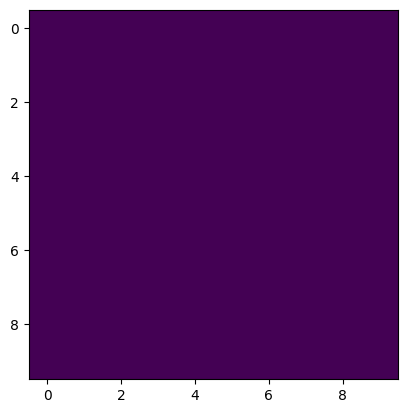

Evaluation 143 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.83it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.10it/s]


Completed. Saving
Time (s) to complete simulation 143: 0.833662748336792


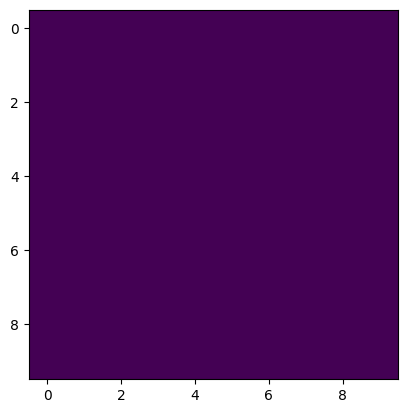

Evaluation 144 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 191.96it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.59it/s]


Completed. Saving
Time (s) to complete simulation 144: 0.8373234272003174


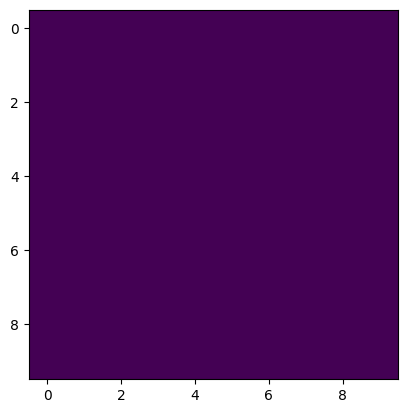

Evaluation 145 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 188.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.90it/s]


Completed. Saving
Time (s) to complete simulation 145: 0.8449187278747559


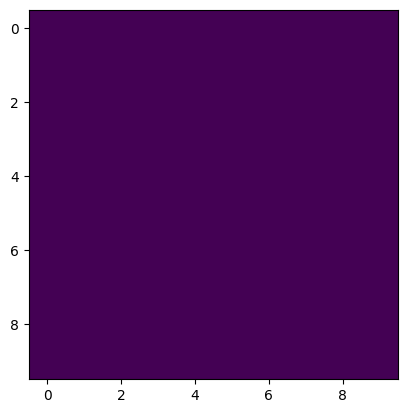

Evaluation 146 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 210.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.27it/s]


Completed. Saving
Time (s) to complete simulation 146: 0.8253931999206543


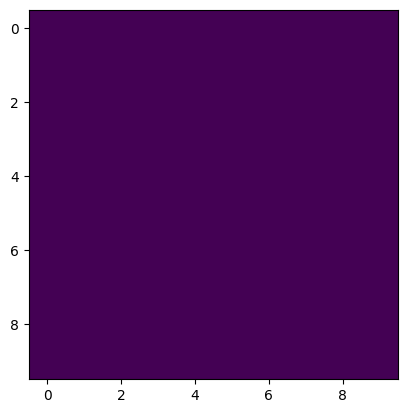

Evaluation 147 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.98it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.38it/s]


Completed. Saving
Time (s) to complete simulation 147: 0.8265876770019531


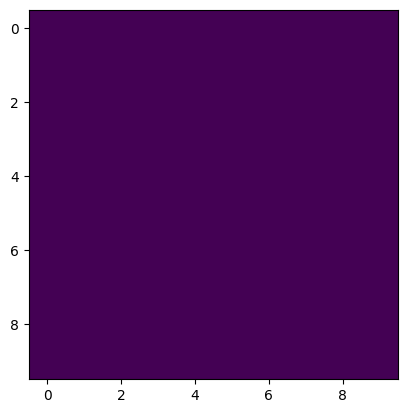

Evaluation 148 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.65it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.51it/s]


Completed. Saving
Time (s) to complete simulation 148: 0.8156075477600098


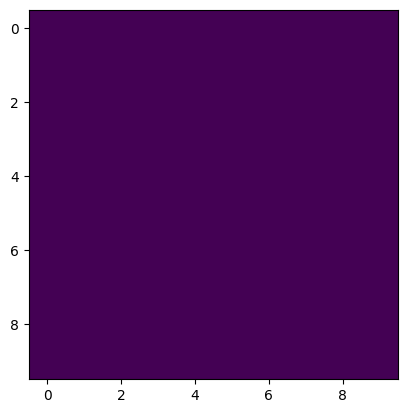

Evaluation 149 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.09it/s]


Completed. Saving
Time (s) to complete simulation 149: 0.850895881652832


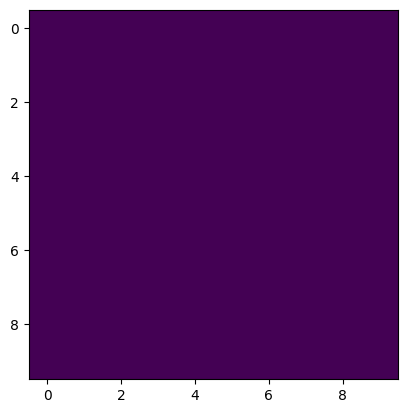

Evaluation 150 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.76it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.91it/s]


Completed. Saving
Time (s) to complete simulation 150: 0.831944465637207


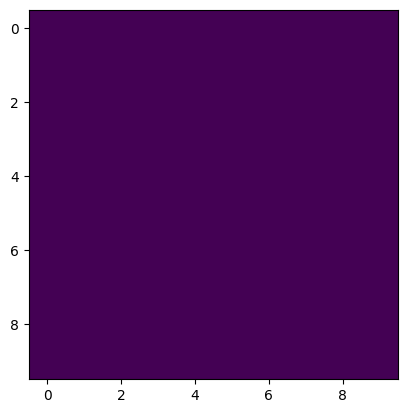

Evaluation 151 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.62it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.64it/s]


Completed. Saving
Time (s) to complete simulation 151: 0.845991849899292


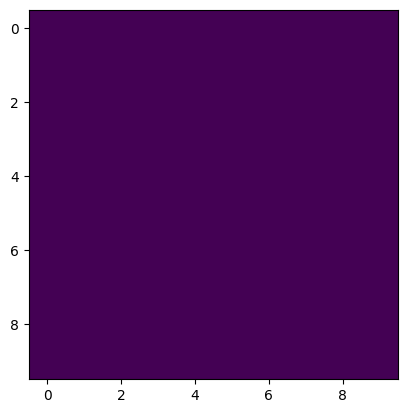

Evaluation 152 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 146.97it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 53.25it/s]


Completed. Saving
Time (s) to complete simulation 152: 1.2976999282836914


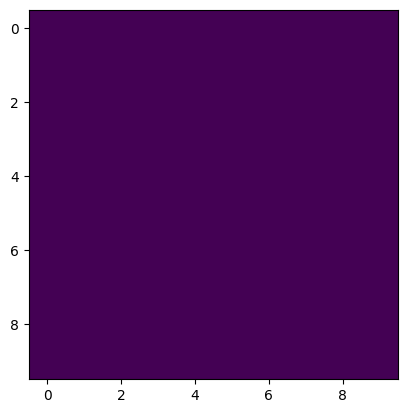

Evaluation 153 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 137.22it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 54.66it/s]


Completed. Saving
Time (s) to complete simulation 153: 1.2937123775482178


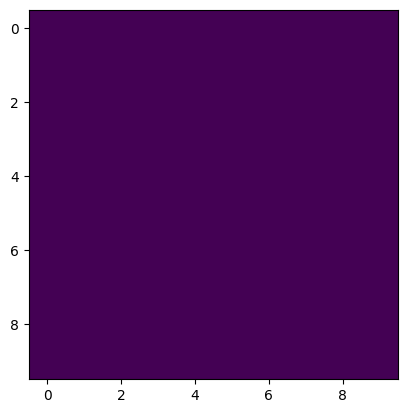

Evaluation 154 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 152.97it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 59.46it/s]


Completed. Saving
Time (s) to complete simulation 154: 1.1843931674957275


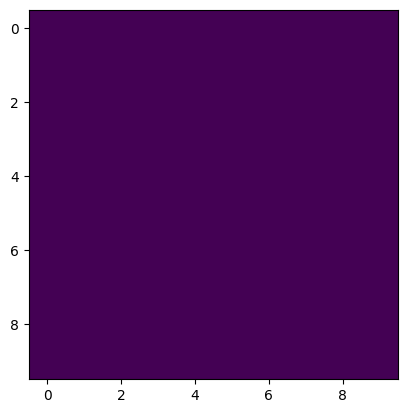

Evaluation 155 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 201.01it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.64it/s]


Completed. Saving
Time (s) to complete simulation 155: 0.8728823661804199


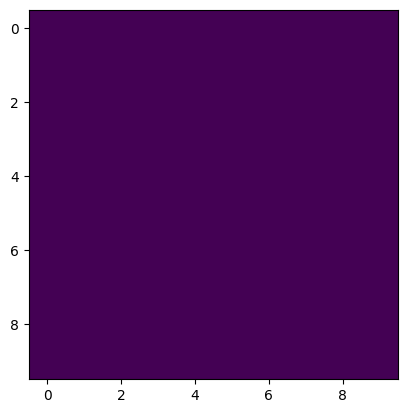

Evaluation 156 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 207.42it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.75it/s]


Completed. Saving
Time (s) to complete simulation 156: 0.8625085353851318


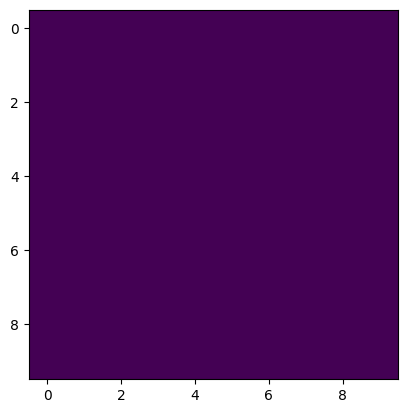

Evaluation 157 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 210.76it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.14it/s]


Completed. Saving
Time (s) to complete simulation 157: 0.8338515758514404


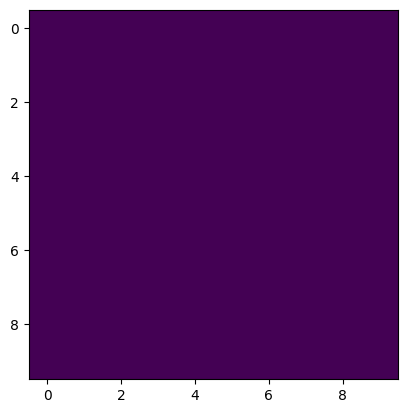

Evaluation 158 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.78it/s]


Completed. Saving
Time (s) to complete simulation 158: 0.8495323657989502


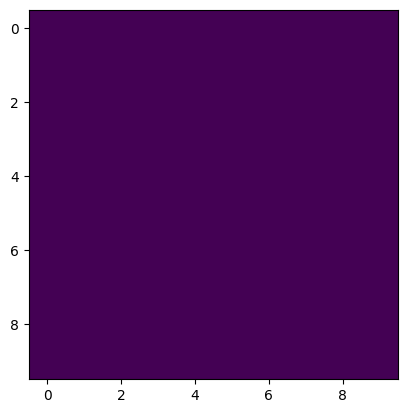

Evaluation 159 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.79it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.04it/s]


Completed. Saving
Time (s) to complete simulation 159: 0.8459205627441406


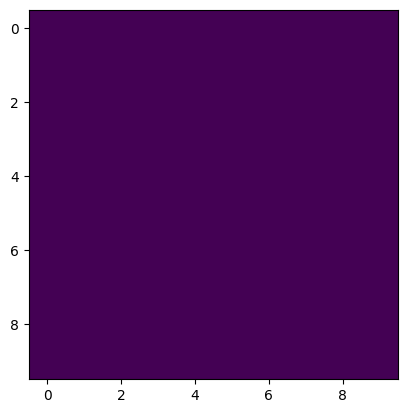

Evaluation 160 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.78it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.32it/s]


Completed. Saving
Time (s) to complete simulation 160: 0.8543469905853271


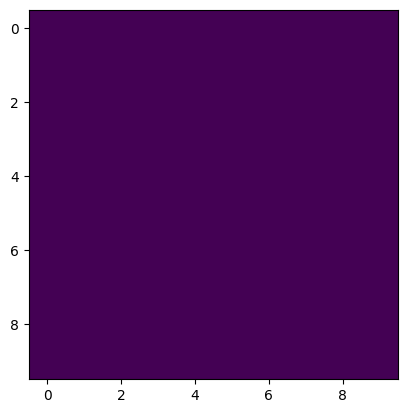

Evaluation 161 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.46it/s]


Completed. Saving
Time (s) to complete simulation 161: 0.8559131622314453


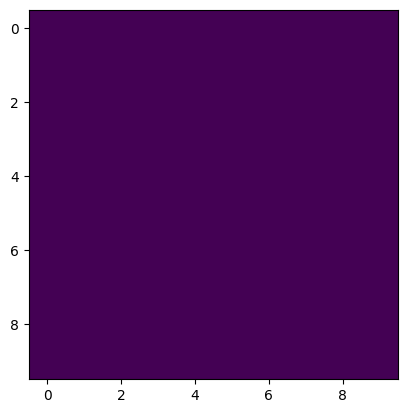

Evaluation 162 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.52it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.05it/s]


Completed. Saving
Time (s) to complete simulation 162: 0.8564345836639404


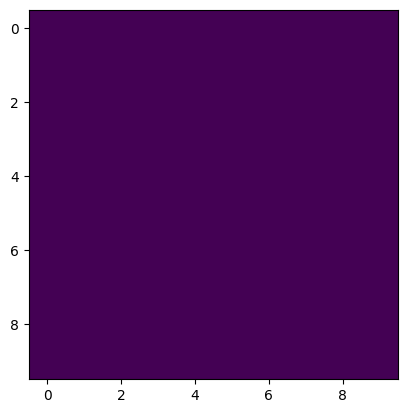

Evaluation 163 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 179.54it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.74it/s]


Completed. Saving
Time (s) to complete simulation 163: 0.8843109607696533


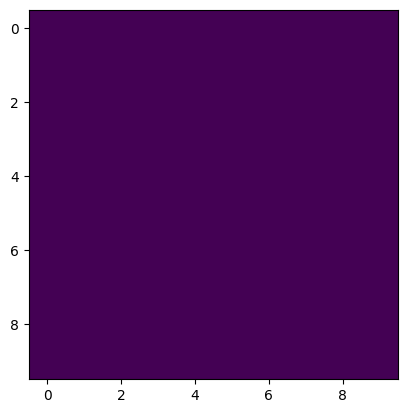

Evaluation 164 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.20it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 61.43it/s]


Completed. Saving
Time (s) to complete simulation 164: 1.0777978897094727


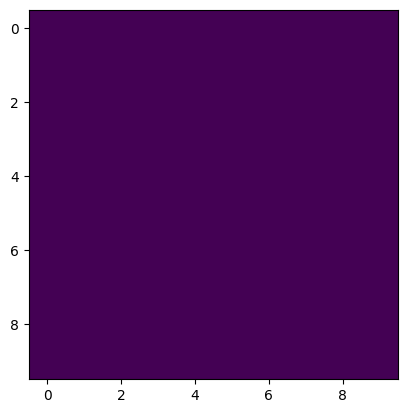

Evaluation 165 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 145.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 53.56it/s]


Completed. Saving
Time (s) to complete simulation 165: 1.2974236011505127


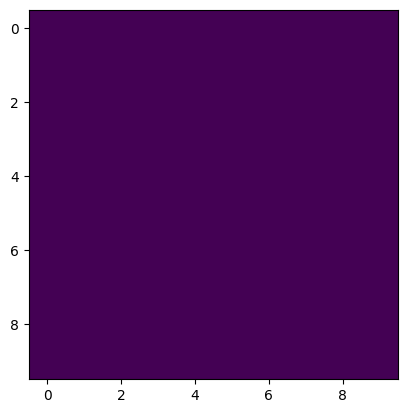

Evaluation 166 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 131.62it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 54.50it/s]


Completed. Saving
Time (s) to complete simulation 166: 1.3159475326538086


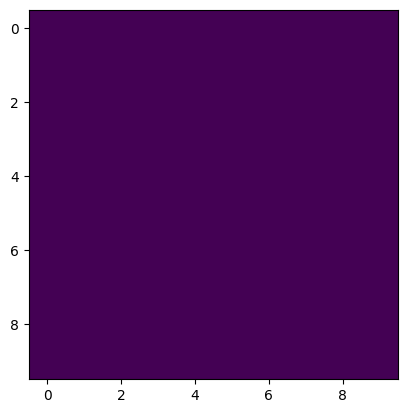

Evaluation 167 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.42it/s]


Completed. Saving
Time (s) to complete simulation 167: 0.8461501598358154


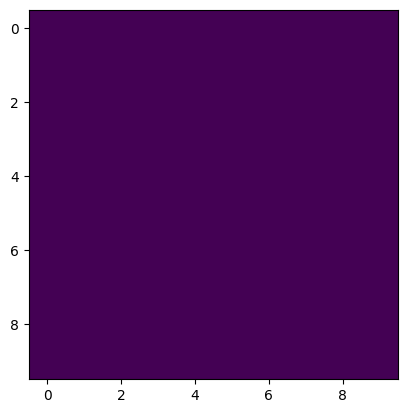

Evaluation 168 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.61it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.80it/s]


Completed. Saving
Time (s) to complete simulation 168: 0.8549821376800537


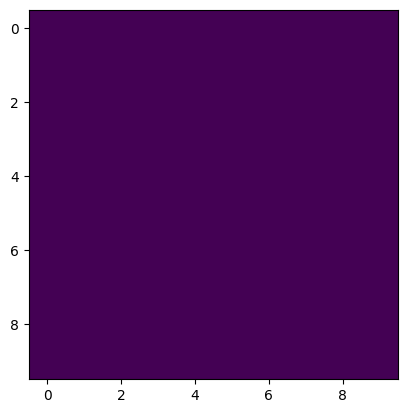

Evaluation 169 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.83it/s]


Completed. Saving
Time (s) to complete simulation 169: 0.8534917831420898


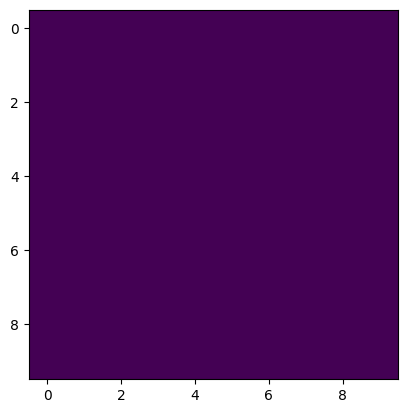

Evaluation 170 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.04it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.69it/s]


Completed. Saving
Time (s) to complete simulation 170: 0.858384370803833


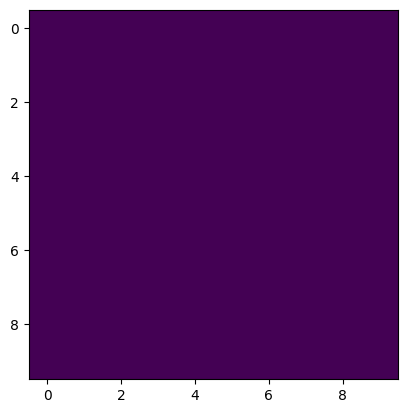

Evaluation 171 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.86it/s]


Completed. Saving
Time (s) to complete simulation 171: 0.8486685752868652


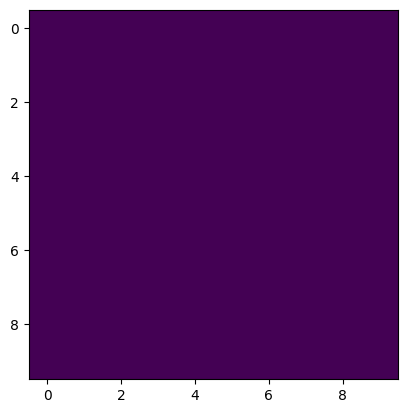

Evaluation 172 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 202.39it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.02it/s]


Completed. Saving
Time (s) to complete simulation 172: 0.8490300178527832


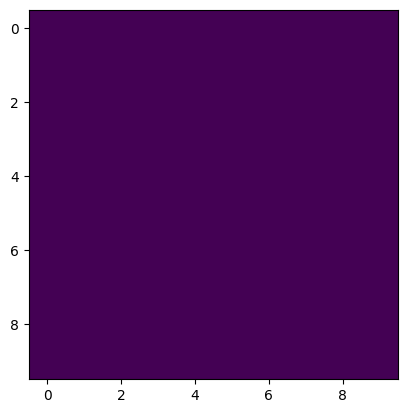

Evaluation 173 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.87it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.37it/s]


Completed. Saving
Time (s) to complete simulation 173: 0.844897985458374


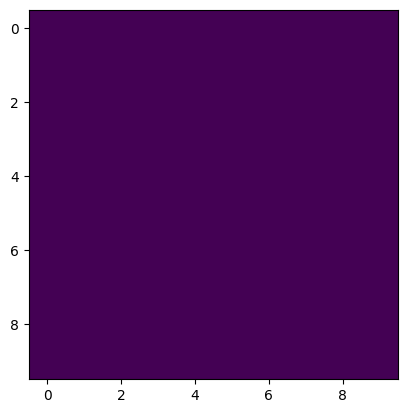

Evaluation 174 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 207.07it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.33it/s]


Completed. Saving
Time (s) to complete simulation 174: 0.8619959354400635


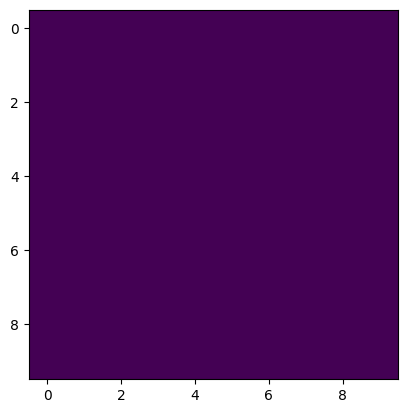

Evaluation 175 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 197.26it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.05it/s]


Completed. Saving
Time (s) to complete simulation 175: 0.9009063243865967


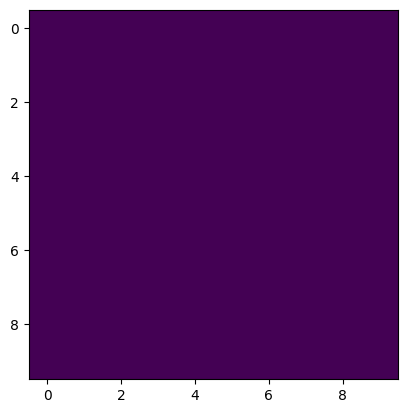

Evaluation 176 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.40it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 72.03it/s]


Completed. Saving
Time (s) to complete simulation 176: 0.956061840057373


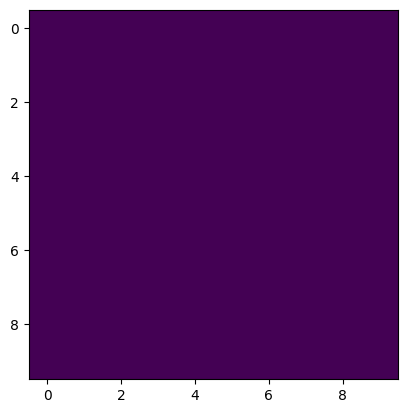

Evaluation 177 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 128.44it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.50it/s]


Completed. Saving
Time (s) to complete simulation 177: 1.2892177104949951


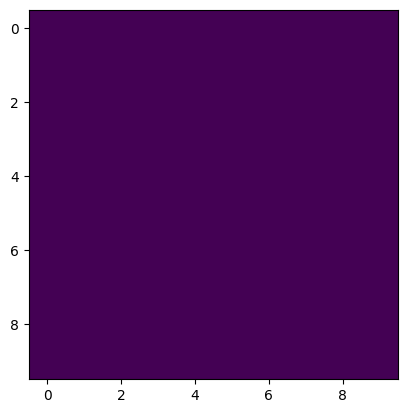

Evaluation 178 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 143.42it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.27it/s]


Completed. Saving
Time (s) to complete simulation 178: 1.3401741981506348


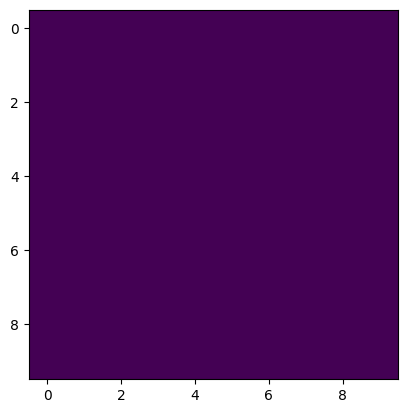

Evaluation 179 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 166.44it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.76it/s]


Completed. Saving
Time (s) to complete simulation 179: 0.9047427177429199


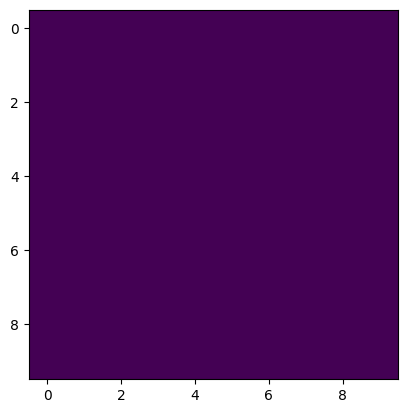

Evaluation 180 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 168.57it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.36it/s]


Completed. Saving
Time (s) to complete simulation 180: 0.8926582336425781


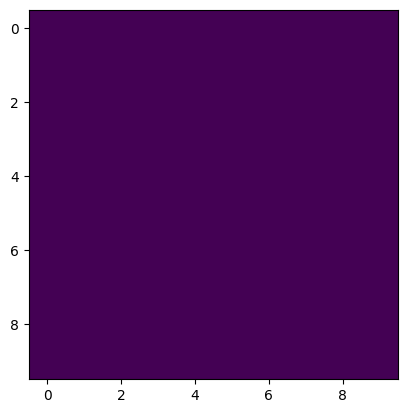

Evaluation 181 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 179.64it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.52it/s]


Completed. Saving
Time (s) to complete simulation 181: 0.9029219150543213


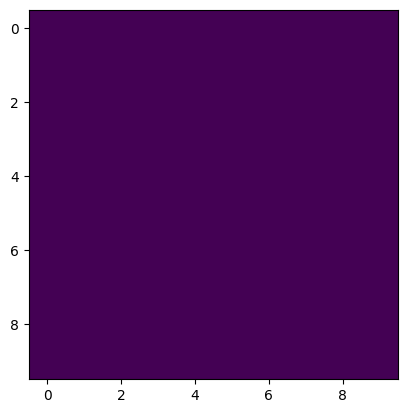

Evaluation 182 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 180.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.48it/s]


Completed. Saving
Time (s) to complete simulation 182: 0.8853366374969482


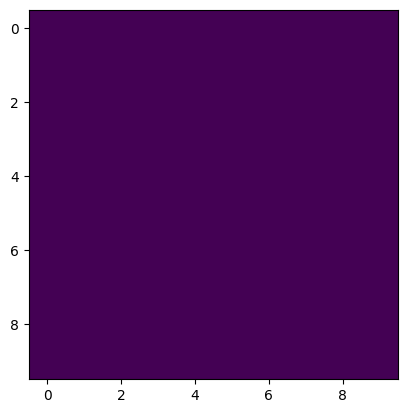

Evaluation 183 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 148.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.97it/s]


Completed. Saving
Time (s) to complete simulation 183: 1.3180568218231201


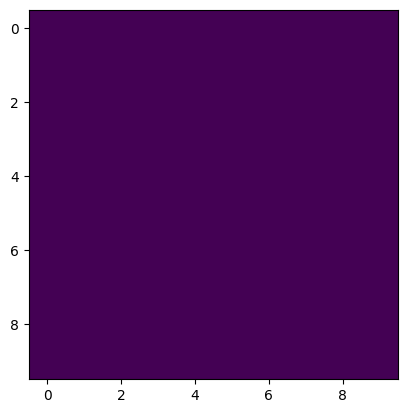

Evaluation 184 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 140.77it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.82it/s]


Completed. Saving
Time (s) to complete simulation 184: 1.3388876914978027


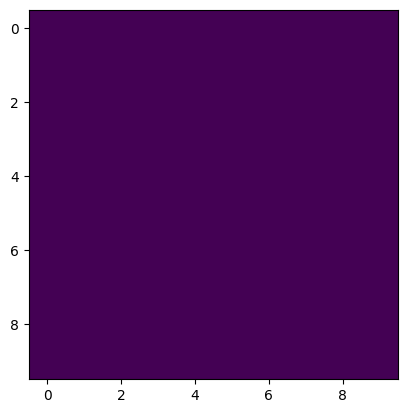

Evaluation 185 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 155.65it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 55.67it/s]


Completed. Saving
Time (s) to complete simulation 185: 1.2384140491485596


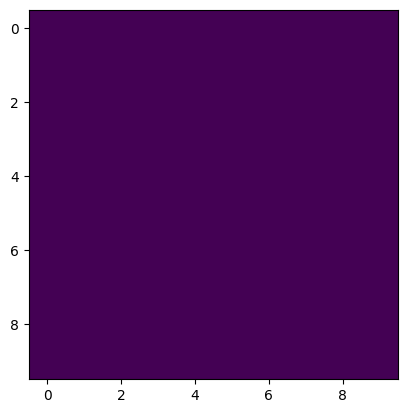

Evaluation 186 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.24it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.05it/s]


Completed. Saving
Time (s) to complete simulation 186: 0.8671510219573975


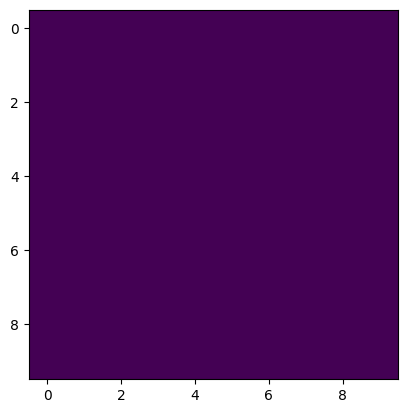

Evaluation 187 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 179.15it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 55.02it/s]


Completed. Saving
Time (s) to complete simulation 187: 1.2081046104431152


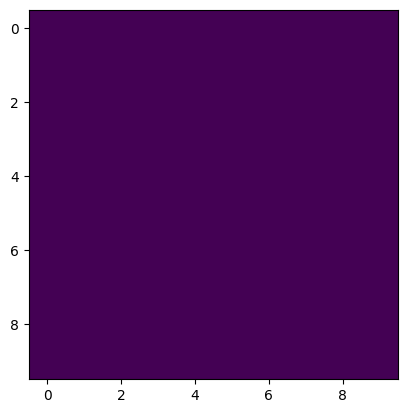

Evaluation 188 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 133.02it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 54.08it/s]


Completed. Saving
Time (s) to complete simulation 188: 1.3184707164764404


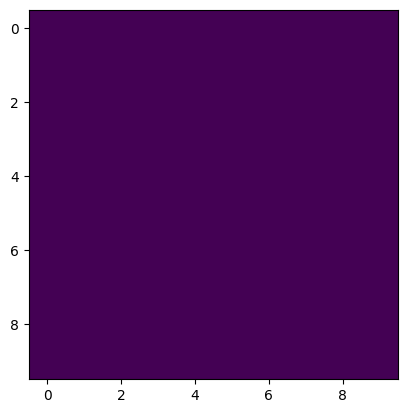

Evaluation 189 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 128.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 52.69it/s]


Completed. Saving
Time (s) to complete simulation 189: 1.3647921085357666


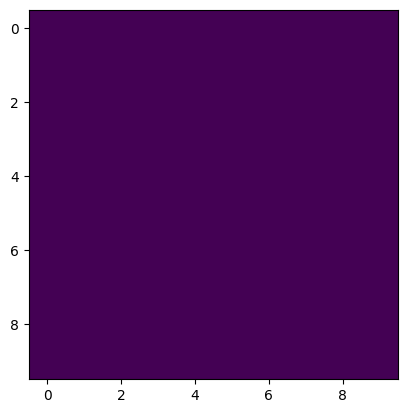

Evaluation 190 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 131.09it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 48.05it/s]


Completed. Saving
Time (s) to complete simulation 190: 1.4433972835540771


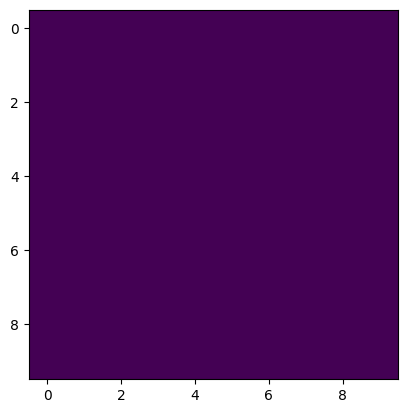

Evaluation 191 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 146.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.83it/s]


Completed. Saving
Time (s) to complete simulation 191: 1.2214996814727783


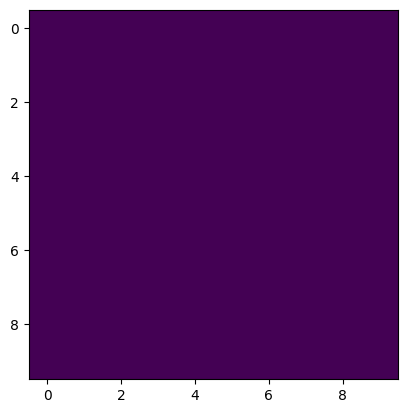

Evaluation 192 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 141.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 58.32it/s]


Completed. Saving
Time (s) to complete simulation 192: 1.2291812896728516


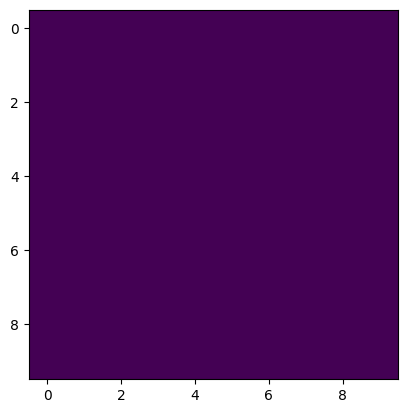

Evaluation 193 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 178.67it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.20it/s]


Completed. Saving
Time (s) to complete simulation 193: 0.8971443176269531


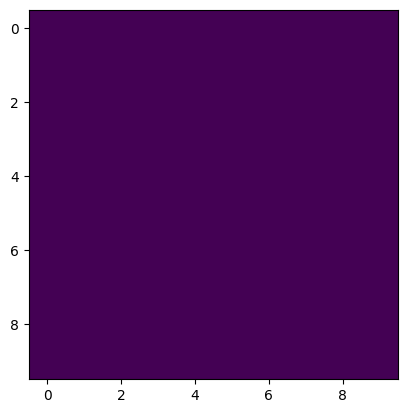

Evaluation 194 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.43it/s]


Completed. Saving
Time (s) to complete simulation 194: 0.880793571472168


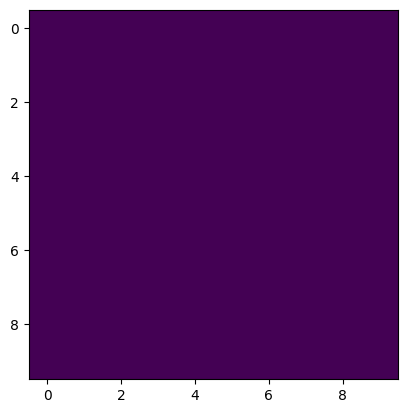

Evaluation 195 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 189.59it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.46it/s]


Completed. Saving
Time (s) to complete simulation 195: 0.8869426250457764


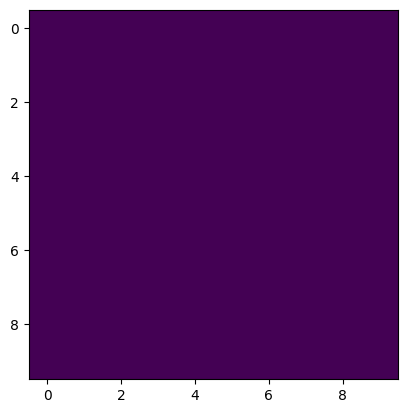

Evaluation 196 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 188.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.39it/s]


Completed. Saving
Time (s) to complete simulation 196: 0.8809092044830322


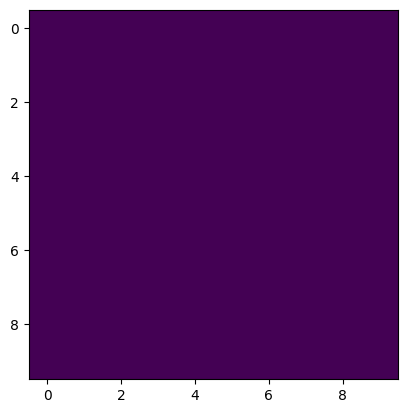

Evaluation 197 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 197.58it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.91it/s]


Completed. Saving
Time (s) to complete simulation 197: 0.8852336406707764


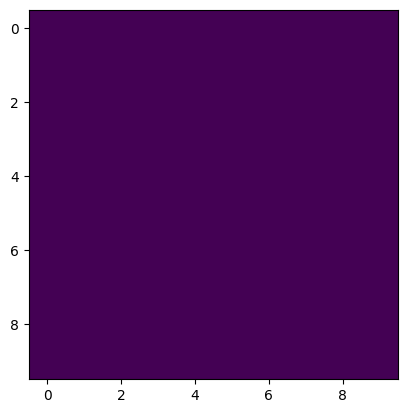

Evaluation 198 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.82it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 68.06it/s]


Completed. Saving
Time (s) to complete simulation 198: 1.0050773620605469


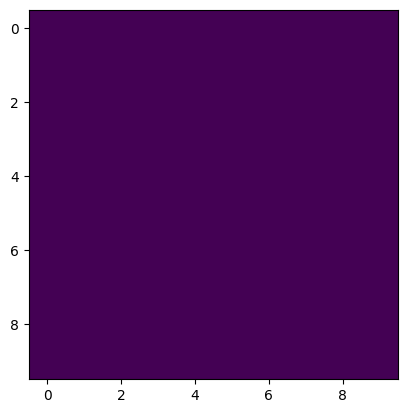

Evaluation 199 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 132.04it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.75it/s]


Completed. Saving
Time (s) to complete simulation 199: 1.4004521369934082


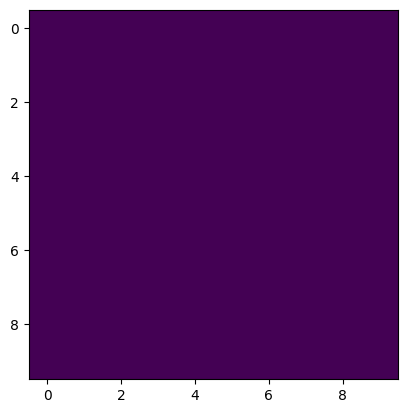

Evaluation 200 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 163.90it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 52.85it/s]


Completed. Saving
Time (s) to complete simulation 200: 1.2667367458343506


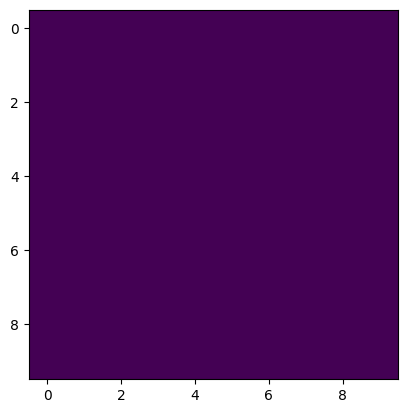

Evaluation 201 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 131.02it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 73.55it/s]


Completed. Saving
Time (s) to complete simulation 201: 1.0830988883972168


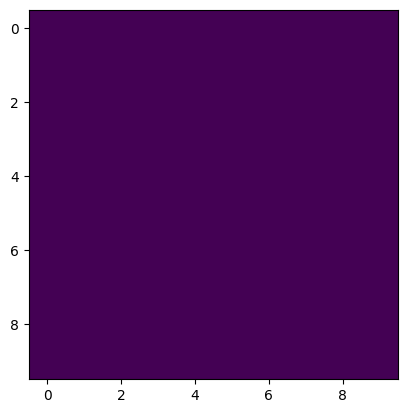

In [8]:
Jx = xs

results_dict = {}
approx_ys = np.zeros(xs.shape[0])
approx_ys1 = np.zeros(xs.shape[0])
approx_ys2 = np.zeros(xs.shape[0])

time_eval = np.zeros(xs.shape[0])

for i in range(0, Jx.shape[0]):
    J_mat = np.array([[0,0,0,0,0],
                      [0,0,Jx[i],0,0],
                      [0,Jx[i],0,Jx[i],0],
                      [0,0,Jx[i],0,0],
                      [0,0,0,0,0]])
    print("Evaluation " +str (i+1) +" of " +str(N_total))
    start_time = time.time()
    np.random.seed(0)
    sq_sim = IsingSim(N = 10, J_mat = J_mat, T = 2.7, save_trajectories=True, eqSteps = 50, mcSteps = 50)  # Intializing the object
    sq_sim.performIsingSim()   # Running the sim
    end_time = time.time()
    time_eval[i]= end_time-start_time
    print("Time (s) to complete simulation " +str(i+1)+ ": " +str(time_eval[i]))
    results_dict[i] = {'sim': sq_sim.results,}

    approx_ys[i] = results_dict[i]['sim']['SpecificHeat']
    approx_ys1[i] = results_dict[i]['sim']['Magnetization']
    approx_ys2[i] = results_dict[i]['sim']['Susceptibility']

    plt.imshow(results_dict[i]['sim']['config'][-1])
    plt.show()

(0.92979401142443, 0.2240525167698384)

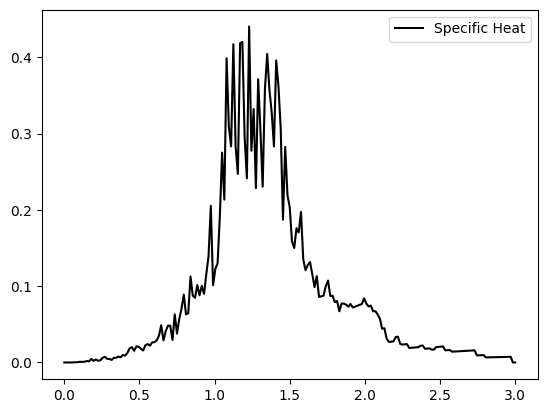

In [9]:
plt.plot(xs, approx_ys, "k", label="Specific Heat")
plt.legend(loc="best")
np.mean(time_eval), np.std(time_eval)

## Symbolic Regression


Problem 6. The code above has calculated the specific heat, magnetization, and susceptibility as a function of chosen parameter. Use PySR to find the symbolic form for one of them.

Note that the data clearly has several regimes, e.g. for the code above we cross the phase transition. It may be difficult to find the equation that describes the behavior of the chosen function across full parameter space. Hence, experiment with:
- Fitting full data set
- Generate the data only above pahse transition
- And only below

 So as the output you have three functions.

# End of Module 2

Congratulations - we are at the end of module 2! Next we are going to dive into the world of differential equations and physics-informed neural networks.